<a href="https://colab.research.google.com/github/GarlandZhang/hairy_gan/blob/master/segmentation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
project_path = '/content/drive/My Drive/hairy_gan/'
dataset_path = os.path.join(project_path, 'face_segment')
src_img_target_path = os.path.join(dataset_path, 'trainI')
label_img_target_path = os.path.join(dataset_path, 'trainS_original')

In [2]:
# from glob import glob
# import os
# import cv2
# import numpy as np
# from PIL import Image

# project_path = '/content/drive/My Drive/hairy_gan'
# files = glob(os.path.join(project_path, 'face_segment', 'trainS_original', '*.jpg'))
# target_folder = os.path.join(project_path, 'face_segment', 'trainS')
# if not os.path.exists(target_folder):
#   os.makedirs(target_folder)

# for f in files:
#   img = cv2.imread(f)
#   img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#   target_img = np.where(img == (255, 255, 0), 255, 0)[:, :, 0]
#   # print(f'{f} vs {os.path.join(target_folder, os.path.basename(f))}')
#   cv2.imwrite(os.path.join(target_folder, os.path.basename(f)), target_img)

In [3]:
# # move images and corresponding segmentation masks into their own folders
# if not os.path.exists(src_img_target_path):
#   os.makedirs(src_img_target_path)

# if not os.path.exists(label_img_target_path):
#   os.makedirs(label_img_target_path)
  
# tree = ET.parse(os.path.join(dataset_path, 'sampleset.xml'))
# root = tree.getroot()
# children = root.getchildren()
# for i in range(len(children) // 2):
#   src_img_path = children[2 * i].get('name').replace('\\', '/')
#   label_img_path = children[2 * i + 1].get('name').replace('\\', '/')
  
#   shutil.copy(os.path.join(dataset_path, src_img_path), os.path.join(src_img_target_path, os.path.basename(src_img_path)))
#   shutil.copy(os.path.join(dataset_path, label_img_path), os.path.join(label_img_target_path, os.path.basename(label_img_path)))

In [4]:
!git clone https://www.github.com/keras-team/keras-contrib.git \
    && cd keras-contrib \
    && pip install git+https://www.github.com/keras-team/keras-contrib.git \
    && python convert_to_tf_keras.py \
    && USE_TF_KERAS=1 python setup.py install

!pip install pillow
!pip install scipy==1.1.0        

fatal: destination path 'keras-contrib' already exists and is not an empty directory.


In [5]:
import xml.etree.ElementTree as ET
import shutil

from __future__ import print_function, division
import scipy
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.optimizers import Adam
from IPython.display import clear_output

import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
import cv2

import PIL
from glob import glob

import tensorflow as tf

tf.compat.v1.disable_v2_behavior()
from tqdm import tqdm

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [6]:
class DataLoader():
    def __init__(self, dataset_path, img_res=(128, 128)):
      self.dataset_path = dataset_path
      self.img_res = img_res

    def load_data(self, domain, batch_size=1, is_testing=False):
      # data_type = "train%s" % domain if not is_testing else "test%s" % domain
      data_type = 'train' + domain # always grab from training since we have no test
      path = glob(os.path.join(self.dataset_path, data_type, '*'))

      batch_images = np.random.choice(path, size=batch_size)

      imgs = []
      for img_path in batch_images:
          img = self.imread(img_path)
          if not is_testing:
              img = scipy.misc.imresize(img, self.img_res)

              if np.random.random() > 0.5:
                  img = np.fliplr(img)
          else:
              img = scipy.misc.imresize(img, self.img_res)

          if domain == 'S':
            # super inefficient to this last but...
            img = np.expand_dims(img[:, :, 0], axis=-1)

          imgs.append(img)

      imgs = np.array(imgs)
      imgs = imgs /127.5 - 1.

      return imgs

    def load_batch(self, batch_size=1, is_testing=False):
      data_type = "train" if not is_testing else "val"

      folder_1 = os.path.join(self.dataset_path, data_type + 'I')
      folder_2 = os.path.join(self.dataset_path, data_type + 'S')
      path_I = glob(os.path.join(folder_1, '*'))
      path_S = glob(os.path.join(folder_2, '*'))

      self.n_batches = int(min(len(path_I), len(path_S)) / batch_size)
      total_samples = self.n_batches * batch_size

      # Sample n_batches * batch_size from each path list so that model sees all
      # samples from both domains
      path_I = np.random.choice(path_I, total_samples, replace=False)
      path_S = np.array([glob(os.path.join(os.path.dirname(path), '../', 'trainS', '*'))[0] for path in path_I])
      # path_S = np.random.choice(path_S, total_samples, replace=False)

      i = 0
      while True:
          batch_I = path_I[i*batch_size:(i+1)*batch_size]
          batch_S = path_S[i*batch_size:(i+1)*batch_size]
          imgs_I, imgs_S = [], []
          for img_I, img_S in zip(batch_I, batch_S):
              img_I = self.imread(img_I)
              img_S = self.imread(img_S)

              img_I = scipy.misc.imresize(img_I, self.img_res)
              img_S = scipy.misc.imresize(img_S, self.img_res)

              if not is_testing and np.random.random() > 0.5:
                      img_I = np.fliplr(img_I)
                      img_S = np.fliplr(img_S)

              # super inefficient to this last but...
              img_S = np.expand_dims(img_S[:, :, 0], axis=-1)

              imgs_I.append(img_I)
              imgs_S.append(img_S)

          imgs_I = np.array(imgs_I)/127.5 - 1.
          imgs_S = np.array(imgs_S) / 255.
          
          i += 1

          if i == self.n_batches - 1:
            path_I = np.random.choice(path_I, total_samples, replace=False)
            path_S = np.array([glob(os.path.join(os.path.dirname(path), '../', 'trainS', '*'))[0] for path in path_I])
            # path_S = np.random.choice(path_S, total_samples, replace=False)
            i = 0
          yield imgs_I, imgs_S

    def imread(self, path):
      return scipy.misc.imread(path, mode='RGB').astype(np.float)

In [7]:
class SegGAN():
  def __init__(self):
    self.img_rows = 128
    self.img_cols = 128
    self.img_channels = 3

    self.img_shape = (self.img_rows, self.img_cols, self.img_channels)

    self.data_loader = DataLoader(dataset_path, img_res=(self.img_rows, self.img_cols))

    # patch = int(self.img_rows / 2**4)
    # self.disc_patch = (patch, patch, 1) # output shape of discriminator
    self.segment_shape = self.img_shape[:-1] + (1,)

    self.gf = 32 # num filters in first layer of gen
    self.df = 64 # num filters in first layer of disc

    optimizer = Adam(0.0002, 0.5, 0.999)

    self.d_I = self.build_discriminator()
    self.d_S = self.build_discriminator(segment=True)

    self.d_I.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
    self.d_S.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

    self.d_I_output_shape = tuple(self.d_I.layers[-1].output.get_shape().as_list()[1:])
    self.d_S_output_shape = tuple(self.d_S.layers[-1].output.get_shape().as_list()[1:])

    self.g_IS = self.build_generator(segment=True)
    self.g_SI = self.build_generator()

    if os.path.exists(os.path.join(project_path, 'd_I.weights')):
      self.d_I.load_weights(os.path.join(project_path, 'd_I.weights'))

    if os.path.exists(os.path.join(project_path, 'd_S.weights')):
      self.d_S.load_weights(os.path.join(project_path, 'd_S.weights'))

    if os.path.exists(os.path.join(project_path, 'g_IS.weights')):
      self.g_IS.load_weights(os.path.join(project_path, 'g_IS.weights'))

    if os.path.exists(os.path.join(project_path, 'g_SI.weights')):
      self.g_SI.load_weights(os.path.join(project_path, 'g_SI.weights'))

    img_I = Input(shape=self.img_shape)
    img_S = Input(shape=self.segment_shape)

    fake_S = self.g_IS(img_I)
    fake_I = self.g_SI(img_S)

    reconstr_I = self.g_SI(fake_S)
    reconstr_S = self.g_IS(fake_I)

    valid_I = self.d_I(fake_I)
    valid_S = self.d_S(fake_S)

    self.combined = Model(inputs=[img_I, img_S], outputs=[valid_I, valid_S, fake_S, fake_I, reconstr_I, reconstr_S])
    self.combined.compile(loss=['mse', 'mse', 'binary_crossentropy', 'mse', 'mae', 'binary_crossentropy'], loss_weights=[1, 1, 10, 1, 1, 10], optimizer=optimizer)

  def build_generator(self, segment=False):
    '''U-net generator'''

    def conv2d(layer_input, filters, f_size=4):
      '''Layers used during downsampling'''
      d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
      d = LeakyReLU(alpha=0.2)(d)
      d = InstanceNormalization()(d)
      return d

    def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
      '''Layers used during upsampling'''
      u = UpSampling2D(size=2)(layer_input)
      u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)

      if dropout_rate:
        u = Dropout(dropout_rate)(u)
      u = InstanceNormalization()(u)
      u = Concatenate()([u, skip_input])
      return u

    if segment:
      d0 = Input(shape=self.img_shape)
    else:
      d0 = Input(shape=self.segment_shape)
    d1 = conv2d(d0, self.gf)
    d2 = conv2d(d1, self.gf * 2)
    d3 = conv2d(d2, self.gf * 4)
    d4 = conv2d(d3, self.gf * 8)

    u1 = deconv2d(d4, d3, self.gf * 4)
    u2 = deconv2d(u1, d2, self.gf * 2)
    u3 = deconv2d(u2, d1, self.gf)

    u4 = UpSampling2D(size=2)(u3)

    if not segment:
      output_img = Conv2D(self.img_channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)
    else:
      output_img = Conv2D(1, kernel_size=4, strides=1, padding='same', activation='sigmoid')(u4)

    return Model(d0, output_img)

  def build_discriminator(self, segment=False):
  
    if not segment:
      input = Input(shape=self.img_shape)
    else:
      input = Input(shape=self.segment_shape)
    d1 = Conv2D(self.df, kernel_size=1, strides=1, padding='same')(input)
    d2 = LeakyReLU(alpha=0.2)(d1)
    d3 = Conv2D(self.df * 2, kernel_size=1, strides=1, padding='same')(d2)
    d4 = BatchNormalization()(d3)
    d5 = LeakyReLU(alpha=0.2)(d4)
    d6 = Conv2D(self.df * 2, kernel_size=1, strides=1, padding='same', activation='sigmoid')(d5)

    return Model(input, d6)

  def train(self, epochs, batch_size=1, sample_interval=50, verbose=True):
    start_time = datetime.datetime.now()

    valid_I = np.ones((batch_size, ) + self.d_I_output_shape)
    fake_gen_I = np.zeros((batch_size, ) + self.d_I_output_shape)

    valid_S = np.ones((batch_size, ) + self.d_S_output_shape)
    fake_gen_S = np.zeros((batch_size, ) + self.d_S_output_shape)

    batch_gen = self.data_loader.load_batch(batch_size)
    for i, elem in enumerate(batch_gen):
      break

    for epoch in range(epochs):
      steps_per_epoch = self.data_loader.n_batches
      for batch_i in tqdm(range(steps_per_epoch), desc=f'Train {epoch} / {epochs}', total=steps_per_epoch):
        if not verbose:
          clear_output()
        imgs_I, imgs_S = next(batch_gen)
        fake_S = self.g_IS.predict(imgs_I)
        fake_I = self.g_SI.predict(imgs_S)

        dI_loss_real = self.d_I.fit(imgs_I, valid_I)
        dI_loss_fake = self.d_I.fit(fake_I, fake_gen_I)

        # dI_loss = 0.5 * np.add(dI_loss_real, dI_loss_fake)

        dS_loss_real = self.d_S.fit(imgs_S, valid_S)
        dS_loss_fake = self.d_S.fit(fake_S, fake_gen_S)

        # dS_loss = 0.5 * np.add(dS_loss_real, dS_loss_fake)

        # d_loss = 0.5 * np.add(dI_loss, dS_loss)

        g_loss = self.combined.fit([imgs_I, imgs_S], [fake_gen_I, fake_gen_S, imgs_S, imgs_I, imgs_I, imgs_S])

        if batch_i % sample_interval == 0:
          self.sample_images(epoch, batch_i)

          # save weights (cannot save model because eager behavior disabled)
          self.d_I.save_weights('d_I.weights')
          shutil.copy('d_I.weights', os.path.join(project_path, 'd_I.weights'))

          self.d_S.save_weights('d_S.weights')
          shutil.copy('d_S.weights', os.path.join(project_path, 'd_S.weights'))

          self.g_IS.save_weights('g_IS.weights')
          shutil.copy('g_IS.weights', os.path.join(project_path, 'g_IS.weights'))

          self.g_SI.save_weights('g_SI.weights')
          shutil.copy('g_SI.weights', os.path.join(project_path, 'g_SI.weights'))
  
  def sample_images(self, epoch, batch_i):
    format_size = 20
    print('=' * format_size)

    r, c = 2, 3

    imgs_I = self.data_loader.load_data(domain="I", batch_size=1, is_testing=True)
    imgs_S = self.data_loader.load_data(domain="S", batch_size=1, is_testing=True)
    
    # Translate images to the other domain
    fake_S = self.g_IS.predict(imgs_I)
    fake_I = self.g_SI.predict(imgs_S)
    # Translate back to original domain
    reconstr_I = self.g_SI.predict(fake_S)
    reconstr_S = self.g_IS.predict(fake_I)

    # super inefficient but works..
    imgs_S = self.batch_gray_to_rgb((imgs_S + 1) * 127.5)
    fake_S = self.batch_gray_to_rgb(self.post_process(fake_S))
    reconstr_S = self.batch_gray_to_rgb(self.post_process(reconstr_S))

    imgs_I = self.post_process(imgs_I)
    fake_I = self.post_process(fake_I)
    reconstr_I = self.post_process(reconstr_I)

    gen_imgs = np.concatenate([imgs_I, fake_S, reconstr_I, imgs_S, fake_I, reconstr_S])

    # Rescale images 0 - 1
    # gen_imgs = 0.5 * gen_imgs + 0.5

    titles = ['Original', 'Translated', 'Reconstructed']
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt])
            axs[i, j].set_title(titles[j])
            axs[i,j].axis('off')
            cnt += 1
    plt.show()

    print('=' * format_size)

    return gen_imgs

  def post_process(self, batch):
    if batch.shape[-1] == 1:
      return batch * 255.
    else:
      return ((batch + 1.) * 127.5) / 255.

  def batch_gray_to_rgb(self, batch):
    return np.array([cv2.cvtColor(np.squeeze(img).astype(np.uint8), cv2.COLOR_GRAY2RGB) for img in batch])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
Train 0 / 10000:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 1/1
5/5 [==============================] - 0s 27ms/step - loss: 0.2683 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2723 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 24ms/step - loss: 0.2522 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2613 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 1s 210ms/step - loss: 18.4534 - model_1_loss: 0.2715 - model_2_loss: 0.2606 - model_3_loss: 0.9263 - model_4_loss: 0.8665


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


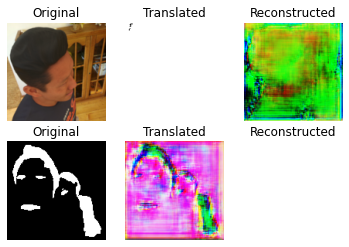

Train 0 / 10000:   2%|▏         | 1/41 [00:18<12:10, 18.26s/it]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.2666 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2712 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2528 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2570 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 41ms/step - loss: 9.1089 - model_1_loss: 0.2701 - model_2_loss: 0.2565 - model_3_loss: 0.2975 - model_4_loss: 0.6409


Train 0 / 10000:   5%|▍         | 2/41 [00:18<08:25, 12.95s/it]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2696 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2671 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2541 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2552 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 42ms/step - loss: 8.8316 - model_1_loss: 0.2658 - model_2_loss: 0.2547 - model_3_loss: 0.2713 - model_4_loss: 0.5145


Train 0 / 10000:   7%|▋         | 3/41 [00:19<05:51,  9.24s/it]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2736 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.2614 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2555 - accuracy: 3.6621e-04
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2521 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 42ms/step - loss: 7.8370 - model_1_loss: 0.2601 - model_2_loss: 0.2519 - model_3_loss: 0.1848 - model_4_loss: 0.6304


Train 0 / 10000:  10%|▉         | 4/41 [00:19<04:05,  6.64s/it]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2785 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.2578 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 14ms/step - loss: 0.2567 - accuracy: 6.1035e-04
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2513 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 7.1432 - model_1_loss: 0.2566 - model_2_loss: 0.2511 - model_3_loss: 0.1395 - model_4_loss: 0.6811


Train 0 / 10000:  12%|█▏        | 5/41 [00:20<02:53,  4.82s/it]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2787 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2540 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2577 - accuracy: 2.4414e-04
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2499 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 6.6775 - model_1_loss: 0.2528 - model_2_loss: 0.2498 - model_3_loss: 0.1232 - model_4_loss: 0.6187


Train 0 / 10000:  15%|█▍        | 6/41 [00:21<02:03,  3.54s/it]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2827 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 14ms/step - loss: 0.2492 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2585 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.2494 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 6.4178 - model_1_loss: 0.2482 - model_2_loss: 0.2493 - model_3_loss: 0.1073 - model_4_loss: 0.5312


Train 0 / 10000:  17%|█▋        | 7/41 [00:21<01:29,  2.65s/it]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2860 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2453 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2590 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2487 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 6.3441 - model_1_loss: 0.2444 - model_2_loss: 0.2486 - model_3_loss: 0.1008 - model_4_loss: 0.5593


Train 0 / 10000:  20%|█▉        | 8/41 [00:22<01:06,  2.02s/it]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2863 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2412 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2597 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.2481 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 44ms/step - loss: 6.1108 - model_1_loss: 0.2403 - model_2_loss: 0.2481 - model_3_loss: 0.0893 - model_4_loss: 0.5402


Train 0 / 10000:  22%|██▏       | 9/41 [00:22<00:50,  1.59s/it]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.2921 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2377 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2602 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.2474 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 6.3685 - model_1_loss: 0.2368 - model_2_loss: 0.2474 - model_3_loss: 0.0915 - model_4_loss: 0.5901


Train 0 / 10000:  24%|██▍       | 10/41 [00:23<00:39,  1.28s/it]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.2882 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.2335 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.2609 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2473 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 5.7553 - model_1_loss: 0.2326 - model_2_loss: 0.2473 - model_3_loss: 0.0766 - model_4_loss: 0.3885


Train 0 / 10000:  27%|██▋       | 11/41 [00:23<00:31,  1.06s/it]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2969 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2311 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.2616 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2465 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 6.2977 - model_1_loss: 0.2303 - model_2_loss: 0.2464 - model_3_loss: 0.0821 - model_4_loss: 0.4924


Train 0 / 10000:  29%|██▉       | 12/41 [00:24<00:26,  1.09it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.2937 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.2290 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2625 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2464 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 5.9082 - model_1_loss: 0.2283 - model_2_loss: 0.2463 - model_3_loss: 0.1144 - model_4_loss: 0.4114


Train 0 / 10000:  32%|███▏      | 13/41 [00:25<00:22,  1.24it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3010 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2262 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2630 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.2454 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 5.6394 - model_1_loss: 0.2255 - model_2_loss: 0.2454 - model_3_loss: 0.0726 - model_4_loss: 0.5014


Train 0 / 10000:  34%|███▍      | 14/41 [00:25<00:19,  1.37it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3029 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.2220 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.2635 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2448 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 41ms/step - loss: 5.7847 - model_1_loss: 0.2213 - model_2_loss: 0.2448 - model_3_loss: 0.0703 - model_4_loss: 0.4812


Train 0 / 10000:  37%|███▋      | 15/41 [00:26<00:17,  1.48it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3027 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2186 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.2642 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2446 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 5.5437 - model_1_loss: 0.2179 - model_2_loss: 0.2446 - model_3_loss: 0.0663 - model_4_loss: 0.4835


Train 0 / 10000:  39%|███▉      | 16/41 [00:26<00:16,  1.55it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3063 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2175 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.2648 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.2437 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 5.6031 - model_1_loss: 0.2168 - model_2_loss: 0.2436 - model_3_loss: 0.0655 - model_4_loss: 0.4388


Train 0 / 10000:  41%|████▏     | 17/41 [00:27<00:14,  1.61it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3098 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.2164 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.2655 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2427 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 5.6830 - model_1_loss: 0.2158 - model_2_loss: 0.2426 - model_3_loss: 0.0781 - model_4_loss: 0.4687


Train 0 / 10000:  44%|████▍     | 18/41 [00:27<00:13,  1.66it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3079 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.2131 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2665 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2438 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 6.3030 - model_1_loss: 0.2125 - model_2_loss: 0.2438 - model_3_loss: 0.1032 - model_4_loss: 0.4957


Train 0 / 10000:  46%|████▋     | 19/41 [00:28<00:12,  1.70it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3087 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2089 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.2672 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2420 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 5.3295 - model_1_loss: 0.2083 - model_2_loss: 0.2420 - model_3_loss: 0.0727 - model_4_loss: 0.3764


Train 0 / 10000:  49%|████▉     | 20/41 [00:28<00:12,  1.70it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3101 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2071 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.2679 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2425 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 5.3885 - model_1_loss: 0.2065 - model_2_loss: 0.2425 - model_3_loss: 0.0660 - model_4_loss: 0.4351


Train 0 / 10000:  51%|█████     | 21/41 [00:29<00:11,  1.73it/s]

Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.3163 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2056 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2685 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.2412 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 5.3399 - model_1_loss: 0.2050 - model_2_loss: 0.2411 - model_3_loss: 0.0586 - model_4_loss: 0.4446


Train 0 / 10000:  54%|█████▎    | 22/41 [00:30<00:10,  1.75it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3173 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2038 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2692 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.2413 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 5.2262 - model_1_loss: 0.2033 - model_2_loss: 0.2413 - model_3_loss: 0.0571 - model_4_loss: 0.3893


Train 0 / 10000:  56%|█████▌    | 23/41 [00:30<00:10,  1.76it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3179 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2015 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2699 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2396 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 42ms/step - loss: 5.1341 - model_1_loss: 0.2010 - model_2_loss: 0.2396 - model_3_loss: 0.0569 - model_4_loss: 0.4081


Train 0 / 10000:  59%|█████▊    | 24/41 [00:31<00:09,  1.75it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3181 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2003 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2708 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.2393 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 5.1799 - model_1_loss: 0.1999 - model_2_loss: 0.2393 - model_3_loss: 0.0656 - model_4_loss: 0.4113


Train 0 / 10000:  61%|██████    | 25/41 [00:31<00:09,  1.77it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3299 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1950 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2718 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2393 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 5.6132 - model_1_loss: 0.1945 - model_2_loss: 0.2393 - model_3_loss: 0.0624 - model_4_loss: 0.5071


Train 0 / 10000:  63%|██████▎   | 26/41 [00:32<00:08,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3270 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.1916 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.2727 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2397 - accuracy: 0.0147
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 5.4141 - model_1_loss: 0.1910 - model_2_loss: 0.2397 - model_3_loss: 0.0556 - model_4_loss: 0.5006


Train 0 / 10000:  66%|██████▌   | 27/41 [00:32<00:07,  1.76it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3199 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1901 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.2732 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.2388 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 5.2732 - model_1_loss: 0.1896 - model_2_loss: 0.2388 - model_3_loss: 0.0553 - model_4_loss: 0.4516


Train 0 / 10000:  68%|██████▊   | 28/41 [00:33<00:07,  1.77it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3280 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.1910 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2738 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.2365 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 5.1600 - model_1_loss: 0.1904 - model_2_loss: 0.2365 - model_3_loss: 0.0558 - model_4_loss: 0.4723


Train 0 / 10000:  71%|███████   | 29/41 [00:34<00:06,  1.77it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3254 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.1849 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2747 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2362 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 5.0423 - model_1_loss: 0.1843 - model_2_loss: 0.2361 - model_3_loss: 0.0521 - model_4_loss: 0.4365


Train 0 / 10000:  73%|███████▎  | 30/41 [00:34<00:06,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3329 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1824 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.2758 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2361 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 5.4037 - model_1_loss: 0.1818 - model_2_loss: 0.2361 - model_3_loss: 0.0513 - model_4_loss: 0.4142


Train 0 / 10000:  76%|███████▌  | 31/41 [00:35<00:05,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3318 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.1814 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.2770 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2325 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 41ms/step - loss: 5.1126 - model_1_loss: 0.1809 - model_2_loss: 0.2323 - model_3_loss: 0.0624 - model_4_loss: 0.4428


Train 0 / 10000:  78%|███████▊  | 32/41 [00:35<00:05,  1.76it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3334 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.1835 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2789 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.2345 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 5.2243 - model_1_loss: 0.1830 - model_2_loss: 0.2344 - model_3_loss: 0.0577 - model_4_loss: 0.4113


Train 0 / 10000:  80%|████████  | 33/41 [00:36<00:04,  1.77it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3398 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1726 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2803 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2312 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 5.4035 - model_1_loss: 0.1719 - model_2_loss: 0.2312 - model_3_loss: 0.0668 - model_4_loss: 0.5456


Train 0 / 10000:  83%|████████▎ | 34/41 [00:36<00:03,  1.77it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3402 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1763 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2819 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2319 - accuracy: 0.0010
Epoch 1/1
5/5 [==============================] - 0s 41ms/step - loss: 5.3204 - model_1_loss: 0.1758 - model_2_loss: 0.2318 - model_3_loss: 0.0698 - model_4_loss: 0.4833


Train 0 / 10000:  85%|████████▌ | 35/41 [00:37<00:03,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3419 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1755 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2833 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.2305 - accuracy: 0.0077
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 5.0893 - model_1_loss: 0.1751 - model_2_loss: 0.2304 - model_3_loss: 0.0488 - model_4_loss: 0.4302


Train 0 / 10000:  88%|████████▊ | 36/41 [00:37<00:02,  1.77it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3429 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1759 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2846 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2285 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 5.1040 - model_1_loss: 0.1755 - model_2_loss: 0.2284 - model_3_loss: 0.0497 - model_4_loss: 0.4717


Train 0 / 10000:  90%|█████████ | 37/41 [00:38<00:02,  1.76it/s]

Epoch 1/1
5/5 [==============================] - 0s 14ms/step - loss: 0.3459 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 14ms/step - loss: 0.1737 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2862 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2265 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.9656 - model_1_loss: 0.1733 - model_2_loss: 0.2264 - model_3_loss: 0.0477 - model_4_loss: 0.3973


Train 0 / 10000:  93%|█████████▎| 38/41 [00:39<00:01,  1.76it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3493 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1722 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2880 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2280 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 4.8395 - model_1_loss: 0.1719 - model_2_loss: 0.2279 - model_3_loss: 0.0508 - model_4_loss: 0.4638


Train 0 / 10000:  95%|█████████▌| 39/41 [00:40<00:01,  1.51it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3387 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1674 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.2895 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.2245 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.8626 - model_1_loss: 0.1670 - model_2_loss: 0.2244 - model_3_loss: 0.0459 - model_4_loss: 0.4118


Train 0 / 10000:  98%|█████████▊| 40/41 [00:40<00:00,  1.58it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3405 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1661 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.2912 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2228 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 4.6827 - model_1_loss: 0.1657 - model_2_loss: 0.2226 - model_3_loss: 0.0453 - model_4_loss: 0.4397


Train 1 / 10000:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3430 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.1632 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.2931 - accuracy: 0.0963
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2215 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 4.6133 - model_1_loss: 0.1628 - model_2_loss: 0.2213 - model_3_loss: 0.0442 - model_4_loss: 0.3748


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


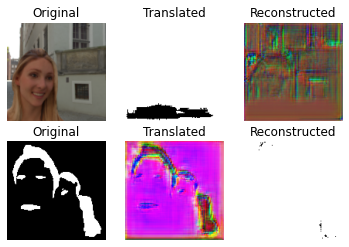

Train 1 / 10000:   2%|▏         | 1/41 [00:01<00:43,  1.09s/it]

Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.3578 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1613 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2951 - accuracy: 0.0950
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2189 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 41ms/step - loss: 4.6211 - model_1_loss: 0.1610 - model_2_loss: 0.2188 - model_3_loss: 0.0445 - model_4_loss: 0.3789


Train 1 / 10000:   5%|▍         | 2/41 [00:01<00:36,  1.07it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3519 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.1612 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2973 - accuracy: 0.0926
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2158 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.8483 - model_1_loss: 0.1609 - model_2_loss: 0.2156 - model_3_loss: 0.0488 - model_4_loss: 0.4144


Train 1 / 10000:   7%|▋         | 3/41 [00:02<00:31,  1.21it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3592 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1533 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.2998 - accuracy: 0.0891
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2134 - accuracy: 0.0302
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.8990 - model_1_loss: 0.1529 - model_2_loss: 0.2131 - model_3_loss: 0.0476 - model_4_loss: 0.3673


Train 1 / 10000:  10%|▉         | 4/41 [00:02<00:27,  1.34it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3640 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1504 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3029 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.2153 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 41ms/step - loss: 4.9019 - model_1_loss: 0.1500 - model_2_loss: 0.2152 - model_3_loss: 0.0544 - model_4_loss: 0.4838


Train 1 / 10000:  12%|█▏        | 5/41 [00:03<00:24,  1.45it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3471 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.1558 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3054 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.2083 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 42ms/step - loss: 4.6977 - model_1_loss: 0.1555 - model_2_loss: 0.2080 - model_3_loss: 0.0546 - model_4_loss: 0.3557


Train 1 / 10000:  15%|█▍        | 6/41 [00:03<00:23,  1.52it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3706 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1585 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3081 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.2117 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 5.1554 - model_1_loss: 0.1582 - model_2_loss: 0.2116 - model_3_loss: 0.0449 - model_4_loss: 0.5692


Train 1 / 10000:  17%|█▋        | 7/41 [00:04<00:21,  1.58it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3661 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1511 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3104 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.2119 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 4.9341 - model_1_loss: 0.1508 - model_2_loss: 0.2117 - model_3_loss: 0.0427 - model_4_loss: 0.4668


Train 1 / 10000:  20%|█▉        | 8/41 [00:05<00:20,  1.63it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3644 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.1485 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3124 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2074 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 4.8693 - model_1_loss: 0.1482 - model_2_loss: 0.2073 - model_3_loss: 0.0451 - model_4_loss: 0.4268


Train 1 / 10000:  22%|██▏       | 9/41 [00:05<00:19,  1.67it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3566 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.1459 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3144 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2071 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 4.7303 - model_1_loss: 0.1456 - model_2_loss: 0.2069 - model_3_loss: 0.0431 - model_4_loss: 0.4226


Train 1 / 10000:  24%|██▍       | 10/41 [00:06<00:18,  1.69it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3757 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1422 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3165 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1953 - accuracy: 0.2111
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 4.9749 - model_1_loss: 0.1419 - model_2_loss: 0.1949 - model_3_loss: 0.0437 - model_4_loss: 0.5410


Train 1 / 10000:  27%|██▋       | 11/41 [00:06<00:17,  1.73it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3764 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1394 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3195 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.2104 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 4.8941 - model_1_loss: 0.1391 - model_2_loss: 0.2102 - model_3_loss: 0.0417 - model_4_loss: 0.4821


Train 1 / 10000:  29%|██▉       | 12/41 [00:07<00:16,  1.73it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3752 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1403 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3214 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1966 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 48ms/step - loss: 4.6301 - model_1_loss: 0.1400 - model_2_loss: 0.1963 - model_3_loss: 0.0428 - model_4_loss: 0.4555


Train 1 / 10000:  32%|███▏      | 13/41 [00:07<00:16,  1.71it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3612 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1426 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3237 - accuracy: 0.8572
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.1996 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 4.9735 - model_1_loss: 0.1423 - model_2_loss: 0.1994 - model_3_loss: 0.0426 - model_4_loss: 0.4248


Train 1 / 10000:  34%|███▍      | 14/41 [00:08<00:15,  1.74it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3770 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1350 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3258 - accuracy: 0.8572
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1883 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 41ms/step - loss: 4.8517 - model_1_loss: 0.1348 - model_2_loss: 0.1879 - model_3_loss: 0.0483 - model_4_loss: 0.4231


Train 1 / 10000:  37%|███▋      | 15/41 [00:09<00:14,  1.76it/s]

Epoch 1/1
5/5 [==============================] - 0s 14ms/step - loss: 0.3750 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1331 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3287 - accuracy: 0.8586
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2004 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.7383 - model_1_loss: 0.1327 - model_2_loss: 0.2002 - model_3_loss: 0.0431 - model_4_loss: 0.4676


Train 1 / 10000:  39%|███▉      | 16/41 [00:09<00:14,  1.75it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3709 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1289 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3307 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.1918 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.6386 - model_1_loss: 0.1286 - model_2_loss: 0.1916 - model_3_loss: 0.0429 - model_4_loss: 0.4305


Train 1 / 10000:  41%|████▏     | 17/41 [00:10<00:13,  1.76it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3829 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.1293 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3327 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1855 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.6583 - model_1_loss: 0.1291 - model_2_loss: 0.1853 - model_3_loss: 0.0404 - model_4_loss: 0.4366


Train 1 / 10000:  44%|████▍     | 18/41 [00:10<00:13,  1.76it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3663 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1343 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.3353 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1728 - accuracy: 0.2730
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 5.1085 - model_1_loss: 0.1341 - model_2_loss: 0.1723 - model_3_loss: 0.0788 - model_4_loss: 0.4016


Train 1 / 10000:  46%|████▋     | 19/41 [00:11<00:12,  1.77it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3629 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.1251 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3390 - accuracy: 0.8610
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2086 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 5.6870 - model_1_loss: 0.1246 - model_2_loss: 0.2085 - model_3_loss: 0.0536 - model_4_loss: 0.5601


Train 1 / 10000:  49%|████▉     | 20/41 [00:11<00:11,  1.77it/s]

Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.3701 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1224 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3405 - accuracy: 0.8602
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1851 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 5.4482 - model_1_loss: 0.1220 - model_2_loss: 0.1849 - model_3_loss: 0.0692 - model_4_loss: 0.6943


Train 1 / 10000:  51%|█████     | 21/41 [00:12<00:11,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3670 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1143 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3419 - accuracy: 0.8586
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1906 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 5.0559 - model_1_loss: 0.1138 - model_2_loss: 0.1905 - model_3_loss: 0.0588 - model_4_loss: 0.6085


Train 1 / 10000:  54%|█████▎    | 22/41 [00:12<00:10,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4062 - accuracy: 0.0011
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1106 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3432 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1833 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 5.1167 - model_1_loss: 0.1103 - model_2_loss: 0.1832 - model_3_loss: 0.0487 - model_4_loss: 0.5813


Train 1 / 10000:  56%|█████▌    | 23/41 [00:13<00:10,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3743 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.1095 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3448 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1816 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 41ms/step - loss: 4.9327 - model_1_loss: 0.1092 - model_2_loss: 0.1814 - model_3_loss: 0.0472 - model_4_loss: 0.5934


Train 1 / 10000:  59%|█████▊    | 24/41 [00:14<00:09,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3916 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.1091 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3465 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.1744 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.6755 - model_1_loss: 0.1088 - model_2_loss: 0.1742 - model_3_loss: 0.0456 - model_4_loss: 0.5148


Train 1 / 10000:  61%|██████    | 25/41 [00:14<00:09,  1.77it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3754 - accuracy: 0.0751
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.1083 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3487 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1663 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 4.7324 - model_1_loss: 0.1080 - model_2_loss: 0.1661 - model_3_loss: 0.0440 - model_4_loss: 0.4935


Train 1 / 10000:  63%|██████▎   | 26/41 [00:15<00:08,  1.77it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4166 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1083 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3515 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.1779 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 41ms/step - loss: 5.0426 - model_1_loss: 0.1081 - model_2_loss: 0.1777 - model_3_loss: 0.0444 - model_4_loss: 0.5195


Train 1 / 10000:  66%|██████▌   | 27/41 [00:15<00:07,  1.77it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3795 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1102 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3537 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.1654 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.6416 - model_1_loss: 0.1099 - model_2_loss: 0.1652 - model_3_loss: 0.0498 - model_4_loss: 0.4741


Train 1 / 10000:  68%|██████▊   | 28/41 [00:16<00:07,  1.77it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3893 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1085 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3561 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1676 - accuracy: 0.2113
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.8637 - model_1_loss: 0.1082 - model_2_loss: 0.1674 - model_3_loss: 0.0440 - model_4_loss: 0.4498


Train 1 / 10000:  71%|███████   | 29/41 [00:16<00:06,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3813 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1105 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3587 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1632 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 4.7532 - model_1_loss: 0.1102 - model_2_loss: 0.1630 - model_3_loss: 0.0510 - model_4_loss: 0.4830


Train 1 / 10000:  73%|███████▎  | 30/41 [00:17<00:06,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3674 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1096 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3609 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1608 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.6868 - model_1_loss: 0.1093 - model_2_loss: 0.1606 - model_3_loss: 0.0571 - model_4_loss: 0.4338


Train 1 / 10000:  76%|███████▌  | 31/41 [00:18<00:05,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.3752 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1145 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3630 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.1615 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 41ms/step - loss: 4.8009 - model_1_loss: 0.1142 - model_2_loss: 0.1613 - model_3_loss: 0.0476 - model_4_loss: 0.4779


Train 1 / 10000:  78%|███████▊  | 32/41 [00:18<00:05,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3688 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1138 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3650 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1612 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.4696 - model_1_loss: 0.1135 - model_2_loss: 0.1610 - model_3_loss: 0.0431 - model_4_loss: 0.3776


Train 1 / 10000:  80%|████████  | 33/41 [00:19<00:04,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3919 - accuracy: 0.0077
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1120 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3669 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1482 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 4.5673 - model_1_loss: 0.1118 - model_2_loss: 0.1480 - model_3_loss: 0.0449 - model_4_loss: 0.3965


Train 1 / 10000:  83%|████████▎ | 34/41 [00:19<00:03,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3858 - accuracy: 0.0030
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1086 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3694 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1493 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 4.5920 - model_1_loss: 0.1084 - model_2_loss: 0.1490 - model_3_loss: 0.0396 - model_4_loss: 0.4838


Train 1 / 10000:  85%|████████▌ | 35/41 [00:20<00:03,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3941 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1055 - accuracy: 6.1035e-05
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3718 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.1566 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 4.4513 - model_1_loss: 0.1054 - model_2_loss: 0.1564 - model_3_loss: 0.0395 - model_4_loss: 0.4538


Train 1 / 10000:  88%|████████▊ | 36/41 [00:20<00:02,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3809 - accuracy: 0.0013
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1050 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3735 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1384 - accuracy: 0.0036
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.3525 - model_1_loss: 0.1048 - model_2_loss: 0.1382 - model_3_loss: 0.0390 - model_4_loss: 0.3963


Train 1 / 10000:  90%|█████████ | 37/41 [00:21<00:02,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3874 - accuracy: 0.0239
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1075 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3761 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1518 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 41ms/step - loss: 4.6823 - model_1_loss: 0.1073 - model_2_loss: 0.1516 - model_3_loss: 0.0407 - model_4_loss: 0.4614


Train 1 / 10000:  93%|█████████▎| 38/41 [00:22<00:01,  1.53it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3846 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1026 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3783 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.1455 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.2819 - model_1_loss: 0.1025 - model_2_loss: 0.1453 - model_3_loss: 0.0434 - model_4_loss: 0.4065


Train 1 / 10000:  95%|█████████▌| 39/41 [00:22<00:01,  1.60it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3946 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1021 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3800 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1360 - accuracy: 0.0035
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 4.5658 - model_1_loss: 0.1019 - model_2_loss: 0.1358 - model_3_loss: 0.0399 - model_4_loss: 0.5140


Train 1 / 10000:  98%|█████████▊| 40/41 [00:23<00:00,  1.65it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4170 - accuracy: 0.0039
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.1003 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3821 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1345 - accuracy: 0.0090
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.3659 - model_1_loss: 0.1002 - model_2_loss: 0.1343 - model_3_loss: 0.0389 - model_4_loss: 0.4140


Train 2 / 10000:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3678 - accuracy: 0.0684
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0973 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3846 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1320 - accuracy: 0.0067
Epoch 1/1
5/5 [==============================] - 0s 42ms/step - loss: 4.3187 - model_1_loss: 0.0972 - model_2_loss: 0.1318 - model_3_loss: 0.0379 - model_4_loss: 0.4096


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


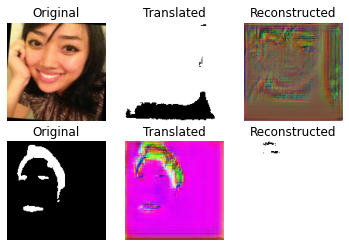

Train 2 / 10000:   2%|▏         | 1/41 [00:01<00:42,  1.07s/it]

Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.3812 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0986 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3871 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.1364 - accuracy: 0.0199
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 4.2070 - model_1_loss: 0.0984 - model_2_loss: 0.1362 - model_3_loss: 0.0381 - model_4_loss: 0.3341


Train 2 / 10000:   5%|▍         | 2/41 [00:01<00:35,  1.08it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3740 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1026 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3889 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1289 - accuracy: 0.0162
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 4.2724 - model_1_loss: 0.1025 - model_2_loss: 0.1288 - model_3_loss: 0.0416 - model_4_loss: 0.4048


Train 2 / 10000:   7%|▋         | 3/41 [00:02<00:30,  1.23it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3805 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0919 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3909 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1285 - accuracy: 0.0209
Epoch 1/1
5/5 [==============================] - 0s 41ms/step - loss: 4.3673 - model_1_loss: 0.0918 - model_2_loss: 0.1284 - model_3_loss: 0.0422 - model_4_loss: 0.4031


Train 2 / 10000:  10%|▉         | 4/41 [00:02<00:27,  1.35it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3863 - accuracy: 6.4697e-04
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0943 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3929 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1364 - accuracy: 0.0201
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 4.1803 - model_1_loss: 0.0942 - model_2_loss: 0.1363 - model_3_loss: 0.0386 - model_4_loss: 0.3503


Train 2 / 10000:  12%|█▏        | 5/41 [00:03<00:24,  1.46it/s]

Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.4007 - accuracy: 0.0025
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0950 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3941 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1237 - accuracy: 0.0160
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.1979 - model_1_loss: 0.0949 - model_2_loss: 0.1236 - model_3_loss: 0.0383 - model_4_loss: 0.3788


Train 2 / 10000:  15%|█▍        | 6/41 [00:03<00:22,  1.54it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3975 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0943 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3958 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.1178 - accuracy: 0.0120
Epoch 1/1
5/5 [==============================] - 0s 42ms/step - loss: 4.3333 - model_1_loss: 0.0942 - model_2_loss: 0.1177 - model_3_loss: 0.0385 - model_4_loss: 0.4174


Train 2 / 10000:  17%|█▋        | 7/41 [00:04<00:21,  1.60it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3845 - accuracy: 0.1448
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0920 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 14ms/step - loss: 0.3979 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1226 - accuracy: 0.0205
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 4.2647 - model_1_loss: 0.0919 - model_2_loss: 0.1225 - model_3_loss: 0.0384 - model_4_loss: 0.4527


Train 2 / 10000:  20%|█▉        | 8/41 [00:05<00:20,  1.64it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3988 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0870 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3999 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.1232 - accuracy: 0.0212
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 4.1277 - model_1_loss: 0.0868 - model_2_loss: 0.1231 - model_3_loss: 0.0375 - model_4_loss: 0.3767


Train 2 / 10000:  22%|██▏       | 9/41 [00:05<00:19,  1.68it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3961 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0876 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4015 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.1237 - accuracy: 0.0202
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.1768 - model_1_loss: 0.0876 - model_2_loss: 0.1237 - model_3_loss: 0.0373 - model_4_loss: 0.4083


Train 2 / 10000:  24%|██▍       | 10/41 [00:06<00:18,  1.71it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4068 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0910 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4032 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1209 - accuracy: 0.0240
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.4904 - model_1_loss: 0.0909 - model_2_loss: 0.1208 - model_3_loss: 0.0381 - model_4_loss: 0.5574


Train 2 / 10000:  27%|██▋       | 11/41 [00:06<00:17,  1.73it/s]

Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.3985 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0902 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4050 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1140 - accuracy: 0.0127
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.1953 - model_1_loss: 0.0901 - model_2_loss: 0.1139 - model_3_loss: 0.0372 - model_4_loss: 0.3897


Train 2 / 10000:  29%|██▉       | 12/41 [00:07<00:16,  1.74it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4219 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0927 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.4072 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1126 - accuracy: 0.0257
Epoch 1/1
5/5 [==============================] - 0s 41ms/step - loss: 4.4145 - model_1_loss: 0.0926 - model_2_loss: 0.1126 - model_3_loss: 0.0417 - model_4_loss: 0.5136


Train 2 / 10000:  32%|███▏      | 13/41 [00:07<00:15,  1.75it/s]

Epoch 1/1
5/5 [==============================] - 0s 14ms/step - loss: 0.4108 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0777 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4092 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.1162 - accuracy: 0.0272
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 4.4050 - model_1_loss: 0.0775 - model_2_loss: 0.1161 - model_3_loss: 0.0538 - model_4_loss: 0.4563


Train 2 / 10000:  34%|███▍      | 14/41 [00:08<00:15,  1.77it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4265 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0847 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4105 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1125 - accuracy: 0.0276
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 4.7610 - model_1_loss: 0.0846 - model_2_loss: 0.1125 - model_3_loss: 0.0634 - model_4_loss: 0.4943


Train 2 / 10000:  37%|███▋      | 15/41 [00:08<00:14,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4006 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0789 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 17ms/step - loss: 0.4117 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1179 - accuracy: 0.0316
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.4963 - model_1_loss: 0.0788 - model_2_loss: 0.1179 - model_3_loss: 0.0504 - model_4_loss: 0.4724


Train 2 / 10000:  39%|███▉      | 16/41 [00:09<00:14,  1.76it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3902 - accuracy: 3.6621e-05
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0832 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4132 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1039 - accuracy: 0.0379
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.3915 - model_1_loss: 0.0830 - model_2_loss: 0.1038 - model_3_loss: 0.0391 - model_4_loss: 0.5152


Train 2 / 10000:  41%|████▏     | 17/41 [00:10<00:13,  1.76it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4057 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0843 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4148 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1116 - accuracy: 0.0059
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 4.4051 - model_1_loss: 0.0842 - model_2_loss: 0.1116 - model_3_loss: 0.0426 - model_4_loss: 0.4405


Train 2 / 10000:  44%|████▍     | 18/41 [00:10<00:12,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4174 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0808 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4168 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1072 - accuracy: 0.0411
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 4.3277 - model_1_loss: 0.0807 - model_2_loss: 0.1072 - model_3_loss: 0.0399 - model_4_loss: 0.5541


Train 2 / 10000:  46%|████▋     | 19/41 [00:11<00:12,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4063 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0776 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4180 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1031 - accuracy: 0.0445
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.2631 - model_1_loss: 0.0776 - model_2_loss: 0.1032 - model_3_loss: 0.0398 - model_4_loss: 0.4318


Train 2 / 10000:  49%|████▉     | 20/41 [00:11<00:11,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3906 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0779 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4196 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1026 - accuracy: 0.0375
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.1820 - model_1_loss: 0.0779 - model_2_loss: 0.1026 - model_3_loss: 0.0378 - model_4_loss: 0.4741


Train 2 / 10000:  51%|█████     | 21/41 [00:12<00:11,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3941 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0774 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4212 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1012 - accuracy: 0.0463
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.1700 - model_1_loss: 0.0774 - model_2_loss: 0.1012 - model_3_loss: 0.0373 - model_4_loss: 0.4443


Train 2 / 10000:  54%|█████▎    | 22/41 [00:12<00:10,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4086 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0793 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4228 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1067 - accuracy: 0.0457
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 4.0970 - model_1_loss: 0.0793 - model_2_loss: 0.1067 - model_3_loss: 0.0377 - model_4_loss: 0.4101


Train 2 / 10000:  56%|█████▌    | 23/41 [00:13<00:09,  1.81it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4053 - accuracy: 8.5449e-05
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0784 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4235 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0976 - accuracy: 0.0652
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.1611 - model_1_loss: 0.0784 - model_2_loss: 0.0976 - model_3_loss: 0.0373 - model_4_loss: 0.4321


Train 2 / 10000:  59%|█████▊    | 24/41 [00:13<00:09,  1.80it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3887 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0777 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4242 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.1005 - accuracy: 0.0464
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 4.1726 - model_1_loss: 0.0776 - model_2_loss: 0.1006 - model_3_loss: 0.0366 - model_4_loss: 0.4563


Train 2 / 10000:  61%|██████    | 25/41 [00:14<00:08,  1.81it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4009 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0748 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4252 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.1046 - accuracy: 0.0413
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.0552 - model_1_loss: 0.0747 - model_2_loss: 0.1046 - model_3_loss: 0.0359 - model_4_loss: 0.3933


Train 2 / 10000:  63%|██████▎   | 26/41 [00:15<00:08,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3974 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0730 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4264 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0979 - accuracy: 0.0538
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 4.0413 - model_1_loss: 0.0729 - model_2_loss: 0.0979 - model_3_loss: 0.0363 - model_4_loss: 0.3898


Train 2 / 10000:  66%|██████▌   | 27/41 [00:15<00:07,  1.80it/s]

Epoch 1/1
5/5 [==============================] - 0s 14ms/step - loss: 0.4054 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0752 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4272 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.1015 - accuracy: 0.0192
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 4.1140 - model_1_loss: 0.0752 - model_2_loss: 0.1016 - model_3_loss: 0.0372 - model_4_loss: 0.3620


Train 2 / 10000:  68%|██████▊   | 28/41 [00:16<00:07,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3872 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0757 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4283 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0995 - accuracy: 0.0783
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.2253 - model_1_loss: 0.0757 - model_2_loss: 0.0995 - model_3_loss: 0.0512 - model_4_loss: 0.3814


Train 2 / 10000:  71%|███████   | 29/41 [00:16<00:06,  1.80it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4057 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0698 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4293 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0917 - accuracy: 0.0529
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.1649 - model_1_loss: 0.0698 - model_2_loss: 0.0917 - model_3_loss: 0.0409 - model_4_loss: 0.4294


Train 2 / 10000:  73%|███████▎  | 30/41 [00:17<00:06,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3986 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0684 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4306 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0986 - accuracy: 0.0560
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 4.0848 - model_1_loss: 0.0683 - model_2_loss: 0.0986 - model_3_loss: 0.0376 - model_4_loss: 0.4075


Train 2 / 10000:  76%|███████▌  | 31/41 [00:17<00:05,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4011 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0698 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4313 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0923 - accuracy: 0.0795
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.9702 - model_1_loss: 0.0698 - model_2_loss: 0.0923 - model_3_loss: 0.0367 - model_4_loss: 0.3683


Train 2 / 10000:  78%|███████▊  | 32/41 [00:18<00:05,  1.77it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4400 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0720 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4320 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0872 - accuracy: 0.0368
Epoch 1/1
5/5 [==============================] - 0s 43ms/step - loss: 4.4226 - model_1_loss: 0.0720 - model_2_loss: 0.0873 - model_3_loss: 0.0370 - model_4_loss: 0.4896


Train 2 / 10000:  80%|████████  | 33/41 [00:19<00:04,  1.76it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4130 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0741 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4333 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0985 - accuracy: 0.0713
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.0568 - model_1_loss: 0.0741 - model_2_loss: 0.0985 - model_3_loss: 0.0365 - model_4_loss: 0.3877


Train 2 / 10000:  83%|████████▎ | 34/41 [00:19<00:03,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3916 - accuracy: 0.0095
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0753 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.4341 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0879 - accuracy: 0.0814
Epoch 1/1
5/5 [==============================] - 0s 41ms/step - loss: 4.0361 - model_1_loss: 0.0752 - model_2_loss: 0.0880 - model_3_loss: 0.0400 - model_4_loss: 0.4045


Train 2 / 10000:  85%|████████▌ | 35/41 [00:20<00:03,  1.77it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4366 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0694 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4349 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0949 - accuracy: 0.0709
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.2821 - model_1_loss: 0.0694 - model_2_loss: 0.0949 - model_3_loss: 0.0356 - model_4_loss: 0.4137


Train 2 / 10000:  88%|████████▊ | 36/41 [00:20<00:02,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3961 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0683 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4361 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0870 - accuracy: 0.1080
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.9622 - model_1_loss: 0.0682 - model_2_loss: 0.0870 - model_3_loss: 0.0383 - model_4_loss: 0.3316


Train 2 / 10000:  90%|█████████ | 37/41 [00:21<00:02,  1.52it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3939 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0682 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4368 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0953 - accuracy: 0.0864
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 4.1014 - model_1_loss: 0.0681 - model_2_loss: 0.0953 - model_3_loss: 0.0363 - model_4_loss: 0.4671


Train 2 / 10000:  93%|█████████▎| 38/41 [00:22<00:01,  1.58it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4135 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0698 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4369 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0969 - accuracy: 0.0869
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.0293 - model_1_loss: 0.0698 - model_2_loss: 0.0970 - model_3_loss: 0.0361 - model_4_loss: 0.3849


Train 2 / 10000:  95%|█████████▌| 39/41 [00:22<00:01,  1.65it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3883 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0713 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.4373 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0834 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.8909 - model_1_loss: 0.0714 - model_2_loss: 0.0835 - model_3_loss: 0.0358 - model_4_loss: 0.3513


Train 2 / 10000:  98%|█████████▊| 40/41 [00:23<00:00,  1.69it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4197 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0724 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4390 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0837 - accuracy: 0.1078
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.0289 - model_1_loss: 0.0724 - model_2_loss: 0.0838 - model_3_loss: 0.0392 - model_4_loss: 0.4398


Train 3 / 10000:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4017 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 14ms/step - loss: 0.0637 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4404 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0850 - accuracy: 0.1002
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.8917 - model_1_loss: 0.0636 - model_2_loss: 0.0851 - model_3_loss: 0.0354 - model_4_loss: 0.3661


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


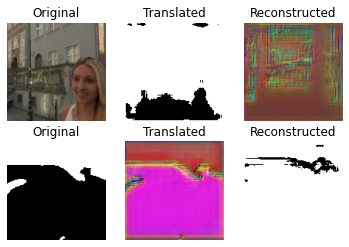

Train 3 / 10000:   2%|▏         | 1/41 [00:01<01:16,  1.90s/it]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4225 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0628 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4415 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0861 - accuracy: 0.0155
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.0009 - model_1_loss: 0.0628 - model_2_loss: 0.0862 - model_3_loss: 0.0355 - model_4_loss: 0.4573


Train 3 / 10000:   5%|▍         | 2/41 [00:02<00:58,  1.50s/it]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3823 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0653 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4429 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0962 - accuracy: 0.1039
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 3.8520 - model_1_loss: 0.0653 - model_2_loss: 0.0963 - model_3_loss: 0.0353 - model_4_loss: 0.3345


Train 3 / 10000:   7%|▋         | 3/41 [00:03<00:46,  1.21s/it]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4377 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0676 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4433 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0832 - accuracy: 0.0813
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 4.2182 - model_1_loss: 0.0677 - model_2_loss: 0.0834 - model_3_loss: 0.0360 - model_4_loss: 0.5334


Train 3 / 10000:  10%|▉         | 4/41 [00:03<00:37,  1.02s/it]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3938 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0666 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4439 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0832 - accuracy: 0.0936
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 4.1559 - model_1_loss: 0.0666 - model_2_loss: 0.0834 - model_3_loss: 0.0356 - model_4_loss: 0.4269


Train 3 / 10000:  12%|█▏        | 5/41 [00:04<00:31,  1.14it/s]

Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.3966 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0643 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4448 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0877 - accuracy: 0.2651
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 4.1722 - model_1_loss: 0.0643 - model_2_loss: 0.0877 - model_3_loss: 0.0448 - model_4_loss: 0.4324


Train 3 / 10000:  15%|█▍        | 6/41 [00:04<00:27,  1.27it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4033 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0607 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4448 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0834 - accuracy: 0.0089
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.8661 - model_1_loss: 0.0607 - model_2_loss: 0.0835 - model_3_loss: 0.0352 - model_4_loss: 0.3654


Train 3 / 10000:  17%|█▋        | 7/41 [00:05<00:24,  1.39it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3772 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0601 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4458 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0769 - accuracy: 0.1220
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.8490 - model_1_loss: 0.0601 - model_2_loss: 0.0770 - model_3_loss: 0.0352 - model_4_loss: 0.4079


Train 3 / 10000:  20%|█▉        | 8/41 [00:05<00:22,  1.48it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4060 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0606 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4469 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0788 - accuracy: 0.0907
Epoch 1/1
5/5 [==============================] - 0s 41ms/step - loss: 3.9517 - model_1_loss: 0.0607 - model_2_loss: 0.0790 - model_3_loss: 0.0349 - model_4_loss: 0.4499


Train 3 / 10000:  22%|██▏       | 9/41 [00:06<00:20,  1.56it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3672 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0623 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4481 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0811 - accuracy: 0.1322
Epoch 1/1
5/5 [==============================] - 0s 41ms/step - loss: 4.0153 - model_1_loss: 0.0623 - model_2_loss: 0.0812 - model_3_loss: 0.0351 - model_4_loss: 0.4527


Train 3 / 10000:  24%|██▍       | 10/41 [00:06<00:19,  1.61it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3853 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0662 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4493 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0798 - accuracy: 0.0482
Epoch 1/1
5/5 [==============================] - 0s 42ms/step - loss: 3.9902 - model_1_loss: 0.0662 - model_2_loss: 0.0800 - model_3_loss: 0.0376 - model_4_loss: 0.4498


Train 3 / 10000:  27%|██▋       | 11/41 [00:07<00:18,  1.65it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4405 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0587 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4508 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0783 - accuracy: 0.1527
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.8618 - model_1_loss: 0.0588 - model_2_loss: 0.0784 - model_3_loss: 0.0356 - model_4_loss: 0.3362


Train 3 / 10000:  29%|██▉       | 12/41 [00:08<00:17,  1.69it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4259 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0578 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4514 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 14ms/step - loss: 0.0704 - accuracy: 0.1707
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.0170 - model_1_loss: 0.0578 - model_2_loss: 0.0705 - model_3_loss: 0.0363 - model_4_loss: 0.4121


Train 3 / 10000:  32%|███▏      | 13/41 [00:08<00:16,  1.70it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4060 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0577 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4517 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0738 - accuracy: 0.2236
Epoch 1/1
5/5 [==============================] - 0s 43ms/step - loss: 3.7186 - model_1_loss: 0.0578 - model_2_loss: 0.0739 - model_3_loss: 0.0353 - model_4_loss: 0.3245


Train 3 / 10000:  34%|███▍      | 14/41 [00:09<00:15,  1.71it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3913 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0590 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4513 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0802 - accuracy: 0.1638
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 4.0165 - model_1_loss: 0.0590 - model_2_loss: 0.0803 - model_3_loss: 0.0345 - model_4_loss: 0.4482


Train 3 / 10000:  37%|███▋      | 15/41 [00:09<00:15,  1.72it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4028 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0609 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4510 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0766 - accuracy: 0.0044
Epoch 1/1
5/5 [==============================] - 0s 43ms/step - loss: 4.0046 - model_1_loss: 0.0610 - model_2_loss: 0.0767 - model_3_loss: 0.0352 - model_4_loss: 0.4572


Train 3 / 10000:  39%|███▉      | 16/41 [00:10<00:14,  1.73it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4223 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0584 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4519 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0771 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 4.1836 - model_1_loss: 0.0585 - model_2_loss: 0.0772 - model_3_loss: 0.0355 - model_4_loss: 0.5697


Train 3 / 10000:  41%|████▏     | 17/41 [00:10<00:13,  1.74it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4299 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0556 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4534 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0841 - accuracy: 0.2059
Epoch 1/1
5/5 [==============================] - 0s 44ms/step - loss: 4.0441 - model_1_loss: 0.0556 - model_2_loss: 0.0842 - model_3_loss: 0.0350 - model_4_loss: 0.4402


Train 3 / 10000:  44%|████▍     | 18/41 [00:11<00:13,  1.72it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3848 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0560 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.4537 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0684 - accuracy: 0.0450
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 4.0304 - model_1_loss: 0.0560 - model_2_loss: 0.0685 - model_3_loss: 0.0369 - model_4_loss: 0.4555


Train 3 / 10000:  46%|████▋     | 19/41 [00:12<00:12,  1.75it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3866 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0555 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4541 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0712 - accuracy: 0.1862
Epoch 1/1
5/5 [==============================] - 0s 41ms/step - loss: 3.9054 - model_1_loss: 0.0555 - model_2_loss: 0.0714 - model_3_loss: 0.0347 - model_4_loss: 0.4260


Train 3 / 10000:  49%|████▉     | 20/41 [00:12<00:12,  1.75it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4036 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0561 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4544 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0798 - accuracy: 0.1011
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.7852 - model_1_loss: 0.0562 - model_2_loss: 0.0800 - model_3_loss: 0.0350 - model_4_loss: 0.3754


Train 3 / 10000:  51%|█████     | 21/41 [00:13<00:11,  1.76it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3678 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0554 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.4553 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0714 - accuracy: 0.1449
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.9164 - model_1_loss: 0.0554 - model_2_loss: 0.0716 - model_3_loss: 0.0345 - model_4_loss: 0.4135


Train 3 / 10000:  54%|█████▎    | 22/41 [00:13<00:10,  1.75it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4120 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0556 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4562 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0671 - accuracy: 0.1116
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.8732 - model_1_loss: 0.0556 - model_2_loss: 0.0673 - model_3_loss: 0.0351 - model_4_loss: 0.4134


Train 3 / 10000:  56%|█████▌    | 23/41 [00:14<00:10,  1.77it/s]

Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.4235 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0537 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4569 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0835 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.9913 - model_1_loss: 0.0538 - model_2_loss: 0.0837 - model_3_loss: 0.0347 - model_4_loss: 0.4295


Train 3 / 10000:  59%|█████▊    | 24/41 [00:14<00:09,  1.77it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4201 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0547 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4582 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0803 - accuracy: 0.0761
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.8714 - model_1_loss: 0.0548 - model_2_loss: 0.0804 - model_3_loss: 0.0345 - model_4_loss: 0.4246


Train 3 / 10000:  61%|██████    | 25/41 [00:15<00:08,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.4575 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0540 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4592 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0683 - accuracy: 0.0549
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.9342 - model_1_loss: 0.0541 - model_2_loss: 0.0685 - model_3_loss: 0.0344 - model_4_loss: 0.4666


Train 3 / 10000:  63%|██████▎   | 26/41 [00:16<00:08,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3776 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0572 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4599 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0734 - accuracy: 0.1978
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.8684 - model_1_loss: 0.0572 - model_2_loss: 0.0735 - model_3_loss: 0.0358 - model_4_loss: 0.4072


Train 3 / 10000:  66%|██████▌   | 27/41 [00:16<00:07,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3997 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0524 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4592 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0652 - accuracy: 0.0029
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.9417 - model_1_loss: 0.0525 - model_2_loss: 0.0654 - model_3_loss: 0.0390 - model_4_loss: 0.4079


Train 3 / 10000:  68%|██████▊   | 28/41 [00:17<00:07,  1.77it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4025 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0540 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4596 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0752 - accuracy: 0.0744
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.7861 - model_1_loss: 0.0540 - model_2_loss: 0.0754 - model_3_loss: 0.0373 - model_4_loss: 0.3997


Train 3 / 10000:  71%|███████   | 29/41 [00:17<00:06,  1.77it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3916 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0549 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4602 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0688 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.9417 - model_1_loss: 0.0549 - model_2_loss: 0.0690 - model_3_loss: 0.0355 - model_4_loss: 0.4278


Train 3 / 10000:  73%|███████▎  | 30/41 [00:18<00:06,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3935 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0514 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.4611 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0689 - accuracy: 0.1134
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.5929 - model_1_loss: 0.0515 - model_2_loss: 0.0691 - model_3_loss: 0.0350 - model_4_loss: 0.3225


Train 3 / 10000:  76%|███████▌  | 31/41 [00:18<00:05,  1.76it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3976 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0510 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4614 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0723 - accuracy: 0.0696
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.8199 - model_1_loss: 0.0510 - model_2_loss: 0.0725 - model_3_loss: 0.0339 - model_4_loss: 0.3657


Train 3 / 10000:  78%|███████▊  | 32/41 [00:19<00:05,  1.77it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3723 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0517 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4617 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0726 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 41ms/step - loss: 3.7657 - model_1_loss: 0.0517 - model_2_loss: 0.0728 - model_3_loss: 0.0347 - model_4_loss: 0.3804


Train 3 / 10000:  80%|████████  | 33/41 [00:20<00:04,  1.76it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3851 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0499 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4627 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0682 - accuracy: 0.0669
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 3.6363 - model_1_loss: 0.0499 - model_2_loss: 0.0684 - model_3_loss: 0.0343 - model_4_loss: 0.3459


Train 3 / 10000:  83%|████████▎ | 34/41 [00:20<00:03,  1.77it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4520 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0510 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4633 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0662 - accuracy: 0.0115
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.7052 - model_1_loss: 0.0512 - model_2_loss: 0.0664 - model_3_loss: 0.0351 - model_4_loss: 0.4027


Train 3 / 10000:  85%|████████▌ | 35/41 [00:21<00:03,  1.77it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4070 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0491 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.4641 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 14ms/step - loss: 0.0796 - accuracy: 0.0662
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.7842 - model_1_loss: 0.0492 - model_2_loss: 0.0798 - model_3_loss: 0.0342 - model_4_loss: 0.4072


Train 3 / 10000:  88%|████████▊ | 36/41 [00:22<00:03,  1.50it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4152 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0526 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4644 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0643 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.7289 - model_1_loss: 0.0527 - model_2_loss: 0.0645 - model_3_loss: 0.0349 - model_4_loss: 0.3808


Train 3 / 10000:  90%|█████████ | 37/41 [00:22<00:02,  1.58it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3942 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0503 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4651 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0686 - accuracy: 0.0208
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.8396 - model_1_loss: 0.0503 - model_2_loss: 0.0688 - model_3_loss: 0.0345 - model_4_loss: 0.4602


Train 3 / 10000:  93%|█████████▎| 38/41 [00:23<00:01,  1.64it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4367 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0482 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4661 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0673 - accuracy: 0.0259
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.6553 - model_1_loss: 0.0483 - model_2_loss: 0.0675 - model_3_loss: 0.0344 - model_4_loss: 0.3760


Train 3 / 10000:  95%|█████████▌| 39/41 [00:23<00:01,  1.69it/s]

Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.4616 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0512 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4670 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0691 - accuracy: 0.0200
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.8371 - model_1_loss: 0.0513 - model_2_loss: 0.0693 - model_3_loss: 0.0349 - model_4_loss: 0.4365


Train 3 / 10000:  98%|█████████▊| 40/41 [00:24<00:00,  1.72it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4227 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0564 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4678 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0618 - accuracy: 0.0315
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.5417 - model_1_loss: 0.0565 - model_2_loss: 0.0620 - model_3_loss: 0.0373 - model_4_loss: 0.3676


Train 4 / 10000:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3927 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0438 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4684 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0729 - accuracy: 0.0873
Epoch 1/1
5/5 [==============================] - 0s 37ms/step - loss: 3.6159 - model_1_loss: 0.0435 - model_2_loss: 0.0730 - model_3_loss: 0.0391 - model_4_loss: 0.3114


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


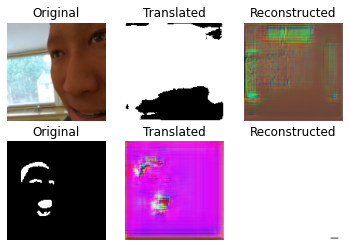

Train 4 / 10000:   2%|▏         | 1/41 [00:01<01:05,  1.63s/it]

Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.4503 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0460 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4680 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0660 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.9267 - model_1_loss: 0.0461 - model_2_loss: 0.0663 - model_3_loss: 0.0431 - model_4_loss: 0.4293


Train 4 / 10000:   5%|▍         | 2/41 [00:02<00:51,  1.32s/it]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4001 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0479 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4690 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0654 - accuracy: 0.0711
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.7591 - model_1_loss: 0.0480 - model_2_loss: 0.0656 - model_3_loss: 0.0357 - model_4_loss: 0.3909


Train 4 / 10000:   7%|▋         | 3/41 [00:02<00:41,  1.09s/it]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4104 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0518 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4696 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0674 - accuracy: 0.1552
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 3.9571 - model_1_loss: 0.0518 - model_2_loss: 0.0675 - model_3_loss: 0.0375 - model_4_loss: 0.4399


Train 4 / 10000:  10%|▉         | 4/41 [00:03<00:34,  1.08it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4235 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0474 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4690 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0662 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 3.8688 - model_1_loss: 0.0474 - model_2_loss: 0.0664 - model_3_loss: 0.0338 - model_4_loss: 0.4199


Train 4 / 10000:  12%|█▏        | 5/41 [00:03<00:29,  1.23it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4127 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0508 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.4698 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0631 - accuracy: 0.0233
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.8621 - model_1_loss: 0.0508 - model_2_loss: 0.0633 - model_3_loss: 0.0425 - model_4_loss: 0.4602


Train 4 / 10000:  15%|█▍        | 6/41 [00:04<00:25,  1.36it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3976 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0416 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4707 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0613 - accuracy: 0.0070
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.1322 - model_1_loss: 0.0415 - model_2_loss: 0.0616 - model_3_loss: 0.0477 - model_4_loss: 0.5339


Train 4 / 10000:  17%|█▋        | 7/41 [00:04<00:23,  1.46it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3824 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0427 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4717 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0734 - accuracy: 0.0253
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.0142 - model_1_loss: 0.0426 - model_2_loss: 0.0736 - model_3_loss: 0.0398 - model_4_loss: 0.4750


Train 4 / 10000:  20%|█▉        | 8/41 [00:05<00:21,  1.54it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4030 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0454 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4726 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0698 - accuracy: 0.0836
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.8811 - model_1_loss: 0.0454 - model_2_loss: 0.0700 - model_3_loss: 0.0375 - model_4_loss: 0.4531


Train 4 / 10000:  22%|██▏       | 9/41 [00:06<00:19,  1.62it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3791 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0482 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4731 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0591 - accuracy: 0.0777
Epoch 1/1
5/5 [==============================] - 0s 41ms/step - loss: 4.0571 - model_1_loss: 0.0482 - model_2_loss: 0.0593 - model_3_loss: 0.0364 - model_4_loss: 0.4808


Train 4 / 10000:  24%|██▍       | 10/41 [00:06<00:18,  1.66it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3662 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0497 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4734 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0556 - accuracy: 0.0989
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 3.6742 - model_1_loss: 0.0496 - model_2_loss: 0.0558 - model_3_loss: 0.0347 - model_4_loss: 0.3430


Train 4 / 10000:  27%|██▋       | 11/41 [00:07<00:17,  1.70it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4086 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0485 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4733 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0700 - accuracy: 0.0891
Epoch 1/1
5/5 [==============================] - 0s 42ms/step - loss: 3.8266 - model_1_loss: 0.0485 - model_2_loss: 0.0701 - model_3_loss: 0.0347 - model_4_loss: 0.4530


Train 4 / 10000:  29%|██▉       | 12/41 [00:07<00:16,  1.71it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3942 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0480 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4730 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0630 - accuracy: 0.1013
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.6376 - model_1_loss: 0.0480 - model_2_loss: 0.0633 - model_3_loss: 0.0345 - model_4_loss: 0.3629


Train 4 / 10000:  32%|███▏      | 13/41 [00:08<00:16,  1.74it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3823 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0462 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.4730 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0615 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.6487 - model_1_loss: 0.0463 - model_2_loss: 0.0617 - model_3_loss: 0.0340 - model_4_loss: 0.3960


Train 4 / 10000:  34%|███▍      | 14/41 [00:08<00:15,  1.73it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3869 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0442 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4738 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0577 - accuracy: 0.0104
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.5860 - model_1_loss: 0.0443 - model_2_loss: 0.0579 - model_3_loss: 0.0336 - model_4_loss: 0.3958


Train 4 / 10000:  37%|███▋      | 15/41 [00:09<00:14,  1.74it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4539 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0448 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4746 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0682 - accuracy: 0.0313
Epoch 1/1
5/5 [==============================] - 0s 42ms/step - loss: 3.7014 - model_1_loss: 0.0449 - model_2_loss: 0.0684 - model_3_loss: 0.0340 - model_4_loss: 0.4152


Train 4 / 10000:  39%|███▉      | 16/41 [00:10<00:14,  1.75it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4123 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0456 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4754 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0572 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.6585 - model_1_loss: 0.0458 - model_2_loss: 0.0574 - model_3_loss: 0.0349 - model_4_loss: 0.3889


Train 4 / 10000:  41%|████▏     | 17/41 [00:10<00:13,  1.77it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4012 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0435 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4764 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0669 - accuracy: 0.1637
Epoch 1/1
5/5 [==============================] - 0s 42ms/step - loss: 3.7846 - model_1_loss: 0.0436 - model_2_loss: 0.0670 - model_3_loss: 0.0342 - model_4_loss: 0.4300


Train 4 / 10000:  44%|████▍     | 18/41 [00:11<00:13,  1.75it/s]

Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.3856 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0446 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4756 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0583 - accuracy: 0.0019
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.5618 - model_1_loss: 0.0446 - model_2_loss: 0.0585 - model_3_loss: 0.0335 - model_4_loss: 0.3898


Train 4 / 10000:  46%|████▋     | 19/41 [00:11<00:12,  1.77it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3513 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0423 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4757 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0538 - accuracy: 0.0859
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 3.5418 - model_1_loss: 0.0424 - model_2_loss: 0.0540 - model_3_loss: 0.0331 - model_4_loss: 0.3772


Train 4 / 10000:  49%|████▉     | 20/41 [00:12<00:11,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3957 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0436 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4761 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0656 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.9334 - model_1_loss: 0.0437 - model_2_loss: 0.0659 - model_3_loss: 0.0335 - model_4_loss: 0.5249


Train 4 / 10000:  51%|█████     | 21/41 [00:12<00:11,  1.80it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3683 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0427 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.4772 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0612 - accuracy: 0.0474
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.8014 - model_1_loss: 0.0428 - model_2_loss: 0.0614 - model_3_loss: 0.0337 - model_4_loss: 0.4150


Train 4 / 10000:  54%|█████▎    | 22/41 [00:13<00:10,  1.80it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4058 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0436 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4783 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0550 - accuracy: 0.0598
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 3.6765 - model_1_loss: 0.0437 - model_2_loss: 0.0553 - model_3_loss: 0.0340 - model_4_loss: 0.3724


Train 4 / 10000:  56%|█████▌    | 23/41 [00:13<00:09,  1.81it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4169 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0437 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4790 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0632 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.8994 - model_1_loss: 0.0438 - model_2_loss: 0.0634 - model_3_loss: 0.0341 - model_4_loss: 0.4658


Train 4 / 10000:  59%|█████▊    | 24/41 [00:14<00:09,  1.81it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3768 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0421 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4801 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0642 - accuracy: 0.1757
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.8154 - model_1_loss: 0.0421 - model_2_loss: 0.0643 - model_3_loss: 0.0373 - model_4_loss: 0.4212


Train 4 / 10000:  61%|██████    | 25/41 [00:15<00:08,  1.82it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3848 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0396 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4792 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0515 - accuracy: 0.2122
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.9187 - model_1_loss: 0.0396 - model_2_loss: 0.0517 - model_3_loss: 0.0372 - model_4_loss: 0.4473


Train 4 / 10000:  63%|██████▎   | 26/41 [00:15<00:08,  1.81it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3875 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0469 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4777 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0523 - accuracy: 0.1879
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.8071 - model_1_loss: 0.0469 - model_2_loss: 0.0526 - model_3_loss: 0.0362 - model_4_loss: 0.4223


Train 4 / 10000:  66%|██████▌   | 27/41 [00:16<00:07,  1.81it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3783 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0418 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4766 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0611 - accuracy: 0.1104
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.9031 - model_1_loss: 0.0418 - model_2_loss: 0.0613 - model_3_loss: 0.0344 - model_4_loss: 0.4863


Train 4 / 10000:  68%|██████▊   | 28/41 [00:16<00:07,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3981 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0403 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4762 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0608 - accuracy: 0.0800
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.7917 - model_1_loss: 0.0403 - model_2_loss: 0.0610 - model_3_loss: 0.0334 - model_4_loss: 0.5018


Train 4 / 10000:  71%|███████   | 29/41 [00:17<00:06,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4502 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0410 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4763 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0590 - accuracy: 0.0688
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 3.5705 - model_1_loss: 0.0412 - model_2_loss: 0.0592 - model_3_loss: 0.0336 - model_4_loss: 0.3609


Train 4 / 10000:  73%|███████▎  | 30/41 [00:17<00:06,  1.80it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4224 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0411 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4768 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0527 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 3.5919 - model_1_loss: 0.0413 - model_2_loss: 0.0530 - model_3_loss: 0.0342 - model_4_loss: 0.4189


Train 4 / 10000:  76%|███████▌  | 31/41 [00:18<00:05,  1.80it/s]

Epoch 1/1
5/5 [==============================] - 0s 16ms/step - loss: 0.3750 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0400 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4777 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0623 - accuracy: 0.1250
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.6223 - model_1_loss: 0.0401 - model_2_loss: 0.0625 - model_3_loss: 0.0334 - model_4_loss: 0.4234


Train 4 / 10000:  78%|███████▊  | 32/41 [00:18<00:05,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3952 - accuracy: 7.3242e-05
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0409 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4784 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0558 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.5034 - model_1_loss: 0.0410 - model_2_loss: 0.0560 - model_3_loss: 0.0331 - model_4_loss: 0.3558


Train 4 / 10000:  80%|████████  | 33/41 [00:19<00:04,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4098 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0411 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4794 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0562 - accuracy: 0.1229
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.7247 - model_1_loss: 0.0412 - model_2_loss: 0.0564 - model_3_loss: 0.0330 - model_4_loss: 0.4132


Train 4 / 10000:  83%|████████▎ | 34/41 [00:20<00:03,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3655 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0403 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4799 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0544 - accuracy: 0.1493
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.6612 - model_1_loss: 0.0404 - model_2_loss: 0.0547 - model_3_loss: 0.0334 - model_4_loss: 0.4172


Train 4 / 10000:  85%|████████▌ | 35/41 [00:20<00:03,  1.53it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3674 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0406 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4803 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0521 - accuracy: 0.0357
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.8007 - model_1_loss: 0.0406 - model_2_loss: 0.0523 - model_3_loss: 0.0335 - model_4_loss: 0.5040


Train 4 / 10000:  88%|████████▊ | 36/41 [00:21<00:03,  1.60it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4648 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0395 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4811 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0613 - accuracy: 0.1602
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 3.3902 - model_1_loss: 0.0396 - model_2_loss: 0.0615 - model_3_loss: 0.0333 - model_4_loss: 0.3228


Train 4 / 10000:  90%|█████████ | 37/41 [00:22<00:02,  1.66it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3618 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0457 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4812 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0501 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 37ms/step - loss: 3.7322 - model_1_loss: 0.0456 - model_2_loss: 0.0504 - model_3_loss: 0.0348 - model_4_loss: 0.4462


Train 4 / 10000:  93%|█████████▎| 38/41 [00:22<00:01,  1.72it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3997 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0373 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4823 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0556 - accuracy: 0.1973
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.6513 - model_1_loss: 0.0374 - model_2_loss: 0.0558 - model_3_loss: 0.0356 - model_4_loss: 0.3824


Train 4 / 10000:  95%|█████████▌| 39/41 [00:23<00:01,  1.74it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4125 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0398 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4819 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0548 - accuracy: 0.0451
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 3.5359 - model_1_loss: 0.0399 - model_2_loss: 0.0550 - model_3_loss: 0.0339 - model_4_loss: 0.3225


Train 4 / 10000:  98%|█████████▊| 40/41 [00:23<00:00,  1.76it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3761 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0413 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4822 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0532 - accuracy: 0.2008
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 3.6460 - model_1_loss: 0.0414 - model_2_loss: 0.0535 - model_3_loss: 0.0356 - model_4_loss: 0.4056


Train 5 / 10000:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3740 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0376 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4824 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0549 - accuracy: 0.1307
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.6614 - model_1_loss: 0.0375 - model_2_loss: 0.0552 - model_3_loss: 0.0337 - model_4_loss: 0.4557


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


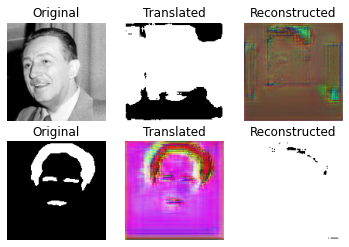

Train 5 / 10000:   2%|▏         | 1/41 [00:01<01:06,  1.67s/it]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4874 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0371 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4828 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0624 - accuracy: 0.0963
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 3.7105 - model_1_loss: 0.0372 - model_2_loss: 0.0627 - model_3_loss: 0.0339 - model_4_loss: 0.4575


Train 5 / 10000:   5%|▍         | 2/41 [00:02<00:52,  1.33s/it]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4008 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0381 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4839 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0504 - accuracy: 0.0343
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 3.9965 - model_1_loss: 0.0382 - model_2_loss: 0.0506 - model_3_loss: 0.0340 - model_4_loss: 0.4367


Train 5 / 10000:   7%|▋         | 3/41 [00:02<00:41,  1.10s/it]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4086 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0389 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.4850 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0632 - accuracy: 0.1659
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.7310 - model_1_loss: 0.0390 - model_2_loss: 0.0634 - model_3_loss: 0.0342 - model_4_loss: 0.4281


Train 5 / 10000:  10%|▉         | 4/41 [00:03<00:34,  1.07it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3979 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0396 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4847 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0504 - accuracy: 0.2013
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 3.5529 - model_1_loss: 0.0397 - model_2_loss: 0.0507 - model_3_loss: 0.0355 - model_4_loss: 0.3899


Train 5 / 10000:  12%|█▏        | 5/41 [00:03<00:29,  1.22it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4101 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0389 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4844 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0562 - accuracy: 0.1448
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 3.4703 - model_1_loss: 0.0390 - model_2_loss: 0.0564 - model_3_loss: 0.0354 - model_4_loss: 0.3295


Train 5 / 10000:  15%|█▍        | 6/41 [00:04<00:25,  1.36it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4012 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0421 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4846 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0580 - accuracy: 0.1623
Epoch 1/1
5/5 [==============================] - 0s 42ms/step - loss: 3.6257 - model_1_loss: 0.0422 - model_2_loss: 0.0582 - model_3_loss: 0.0337 - model_4_loss: 0.3882


Train 5 / 10000:  17%|█▋        | 7/41 [00:04<00:23,  1.46it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3983 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0396 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4845 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0478 - accuracy: 0.1826
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 4.0720 - model_1_loss: 0.0396 - model_2_loss: 0.0481 - model_3_loss: 0.0534 - model_4_loss: 0.5178


Train 5 / 10000:  20%|█▉        | 8/41 [00:05<00:21,  1.56it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4302 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0329 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4847 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0657 - accuracy: 0.1526
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.8935 - model_1_loss: 0.0315 - model_2_loss: 0.0659 - model_3_loss: 0.0366 - model_4_loss: 0.5067


Train 5 / 10000:  22%|██▏       | 9/41 [00:06<00:19,  1.62it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3790 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0315 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4850 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0534 - accuracy: 0.1372
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.8212 - model_1_loss: 0.0314 - model_2_loss: 0.0537 - model_3_loss: 0.0404 - model_4_loss: 0.4950


Train 5 / 10000:  24%|██▍       | 10/41 [00:06<00:18,  1.66it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3711 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0308 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4854 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0515 - accuracy: 0.1871
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.9383 - model_1_loss: 0.0308 - model_2_loss: 0.0518 - model_3_loss: 0.0541 - model_4_loss: 0.4783


Train 5 / 10000:  27%|██▋       | 11/41 [00:07<00:17,  1.69it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3861 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0369 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4853 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0506 - accuracy: 0.1414
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.7902 - model_1_loss: 0.0368 - model_2_loss: 0.0509 - model_3_loss: 0.1349 - model_4_loss: 0.5249


Train 5 / 10000:  29%|██▉       | 12/41 [00:07<00:16,  1.73it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3895 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0341 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4856 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0556 - accuracy: 0.1165
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.5047 - model_1_loss: 0.0335 - model_2_loss: 0.0559 - model_3_loss: 0.1026 - model_4_loss: 0.4779


Train 5 / 10000:  32%|███▏      | 13/41 [00:08<00:16,  1.74it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3560 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0372 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4867 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0597 - accuracy: 0.1487
Epoch 1/1
5/5 [==============================] - 0s 41ms/step - loss: 4.3824 - model_1_loss: 0.0368 - model_2_loss: 0.0599 - model_3_loss: 0.0734 - model_4_loss: 0.5263


Train 5 / 10000:  34%|███▍      | 14/41 [00:08<00:15,  1.74it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3670 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0426 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4870 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0548 - accuracy: 0.1105
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 4.1875 - model_1_loss: 0.0424 - model_2_loss: 0.0551 - model_3_loss: 0.0504 - model_4_loss: 0.4552


Train 5 / 10000:  37%|███▋      | 15/41 [00:09<00:14,  1.75it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4005 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0408 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4877 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0564 - accuracy: 0.1819
Epoch 1/1
5/5 [==============================] - 0s 42ms/step - loss: 4.1283 - model_1_loss: 0.0407 - model_2_loss: 0.0565 - model_3_loss: 0.0458 - model_4_loss: 0.5231


Train 5 / 10000:  39%|███▉      | 16/41 [00:10<00:14,  1.76it/s]

Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.3727 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0436 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4868 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0482 - accuracy: 0.1979
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.9167 - model_1_loss: 0.0436 - model_2_loss: 0.0485 - model_3_loss: 0.0421 - model_4_loss: 0.5340


Train 5 / 10000:  41%|████▏     | 17/41 [00:10<00:13,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.4027 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0414 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4860 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0560 - accuracy: 0.0661
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.9119 - model_1_loss: 0.0414 - model_2_loss: 0.0563 - model_3_loss: 0.0389 - model_4_loss: 0.5186


Train 5 / 10000:  44%|████▍     | 18/41 [00:11<00:12,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3680 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0378 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4870 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0518 - accuracy: 0.1787
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.9309 - model_1_loss: 0.0378 - model_2_loss: 0.0520 - model_3_loss: 0.0384 - model_4_loss: 0.4906


Train 5 / 10000:  46%|████▋     | 19/41 [00:11<00:12,  1.77it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4357 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0375 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4876 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0579 - accuracy: 0.0647
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.9752 - model_1_loss: 0.0376 - model_2_loss: 0.0582 - model_3_loss: 0.0377 - model_4_loss: 0.5462


Train 5 / 10000:  49%|████▉     | 20/41 [00:12<00:11,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3650 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0410 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4892 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0534 - accuracy: 0.1805
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.6494 - model_1_loss: 0.0410 - model_2_loss: 0.0537 - model_3_loss: 0.0387 - model_4_loss: 0.4137


Train 5 / 10000:  51%|█████     | 21/41 [00:12<00:11,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3683 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0383 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4902 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0481 - accuracy: 0.2086
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.6752 - model_1_loss: 0.0383 - model_2_loss: 0.0484 - model_3_loss: 0.0366 - model_4_loss: 0.4418


Train 5 / 10000:  54%|█████▎    | 22/41 [00:13<00:10,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4283 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0349 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4907 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0575 - accuracy: 0.1529
Epoch 1/1
5/5 [==============================] - 0s 41ms/step - loss: 3.8353 - model_1_loss: 0.0349 - model_2_loss: 0.0578 - model_3_loss: 0.0357 - model_4_loss: 0.4555


Train 5 / 10000:  56%|█████▌    | 23/41 [00:13<00:10,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3764 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0342 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4919 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0447 - accuracy: 0.1654
Epoch 1/1
5/5 [==============================] - 0s 37ms/step - loss: 3.9131 - model_1_loss: 0.0342 - model_2_loss: 0.0450 - model_3_loss: 0.0359 - model_4_loss: 0.5278


Train 5 / 10000:  59%|█████▊    | 24/41 [00:14<00:09,  1.80it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4142 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0358 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4931 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0522 - accuracy: 0.1818
Epoch 1/1
5/5 [==============================] - 0s 41ms/step - loss: 3.4846 - model_1_loss: 0.0359 - model_2_loss: 0.0524 - model_3_loss: 0.0357 - model_4_loss: 0.3605


Train 5 / 10000:  61%|██████    | 25/41 [00:15<00:08,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3778 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0377 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4932 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0512 - accuracy: 0.1867
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.7675 - model_1_loss: 0.0378 - model_2_loss: 0.0514 - model_3_loss: 0.0362 - model_4_loss: 0.4165


Train 5 / 10000:  63%|██████▎   | 26/41 [00:15<00:08,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4013 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0357 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4920 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0535 - accuracy: 0.1046
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 3.8597 - model_1_loss: 0.0357 - model_2_loss: 0.0538 - model_3_loss: 0.0354 - model_4_loss: 0.5119


Train 5 / 10000:  66%|██████▌   | 27/41 [00:16<00:07,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3837 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0337 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4924 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0539 - accuracy: 0.1549
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.6931 - model_1_loss: 0.0337 - model_2_loss: 0.0541 - model_3_loss: 0.0354 - model_4_loss: 0.3998


Train 5 / 10000:  68%|██████▊   | 28/41 [00:16<00:07,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.3634 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0355 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4933 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0488 - accuracy: 0.2204
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 3.6027 - model_1_loss: 0.0357 - model_2_loss: 0.0491 - model_3_loss: 0.0355 - model_4_loss: 0.3694


Train 5 / 10000:  71%|███████   | 29/41 [00:17<00:06,  1.80it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3826 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0361 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4942 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0424 - accuracy: 0.2416
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.8072 - model_1_loss: 0.0361 - model_2_loss: 0.0426 - model_3_loss: 0.0366 - model_4_loss: 0.5500


Train 5 / 10000:  73%|███████▎  | 30/41 [00:17<00:06,  1.80it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3411 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0319 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4941 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0533 - accuracy: 0.1828
Epoch 1/1
5/5 [==============================] - 0s 41ms/step - loss: 3.6849 - model_1_loss: 0.0318 - model_2_loss: 0.0536 - model_3_loss: 0.0353 - model_4_loss: 0.4516


Train 5 / 10000:  76%|███████▌  | 31/41 [00:18<00:05,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3814 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0311 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4939 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0479 - accuracy: 0.1710
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.6657 - model_1_loss: 0.0311 - model_2_loss: 0.0482 - model_3_loss: 0.0343 - model_4_loss: 0.4451


Train 5 / 10000:  78%|███████▊  | 32/41 [00:18<00:05,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3410 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0329 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4942 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0523 - accuracy: 0.1016
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.5041 - model_1_loss: 0.0329 - model_2_loss: 0.0526 - model_3_loss: 0.0339 - model_4_loss: 0.3849


Train 5 / 10000:  80%|████████  | 33/41 [00:19<00:04,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.3523 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0339 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4953 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0502 - accuracy: 0.1561
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.6949 - model_1_loss: 0.0339 - model_2_loss: 0.0505 - model_3_loss: 0.0340 - model_4_loss: 0.4425


Train 5 / 10000:  83%|████████▎ | 34/41 [00:20<00:04,  1.54it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4263 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0328 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4966 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0466 - accuracy: 0.2030
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 3.4223 - model_1_loss: 0.0329 - model_2_loss: 0.0468 - model_3_loss: 0.0340 - model_4_loss: 0.3623


Train 5 / 10000:  85%|████████▌ | 35/41 [00:20<00:03,  1.61it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3547 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0326 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4960 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0444 - accuracy: 0.2270
Epoch 1/1
5/5 [==============================] - 0s 41ms/step - loss: 3.4955 - model_1_loss: 0.0327 - model_2_loss: 0.0447 - model_3_loss: 0.0345 - model_4_loss: 0.3934


Train 5 / 10000:  88%|████████▊ | 36/41 [00:21<00:03,  1.65it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3801 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0335 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4958 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0479 - accuracy: 0.1978
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.6797 - model_1_loss: 0.0335 - model_2_loss: 0.0482 - model_3_loss: 0.0347 - model_4_loss: 0.4952


Train 5 / 10000:  90%|█████████ | 37/41 [00:22<00:02,  1.69it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3693 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0302 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4958 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0487 - accuracy: 0.1350
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.6354 - model_1_loss: 0.0302 - model_2_loss: 0.0491 - model_3_loss: 0.0347 - model_4_loss: 0.4707


Train 5 / 10000:  93%|█████████▎| 38/41 [00:22<00:01,  1.73it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3730 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0292 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4966 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0494 - accuracy: 0.1157
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 3.4880 - model_1_loss: 0.0292 - model_2_loss: 0.0497 - model_3_loss: 0.0350 - model_4_loss: 0.4349


Train 5 / 10000:  95%|█████████▌| 39/41 [00:23<00:01,  1.75it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3693 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0289 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4983 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0509 - accuracy: 0.1680
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.4067 - model_1_loss: 0.0289 - model_2_loss: 0.0512 - model_3_loss: 0.0343 - model_4_loss: 0.3957


Train 5 / 10000:  98%|█████████▊| 40/41 [00:23<00:00,  1.77it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3960 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0287 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4988 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0473 - accuracy: 0.1615
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 3.6939 - model_1_loss: 0.0288 - model_2_loss: 0.0476 - model_3_loss: 0.0334 - model_4_loss: 0.4653


Train 6 / 10000:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4198 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0307 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4995 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0475 - accuracy: 0.0807
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.7240 - model_1_loss: 0.0306 - model_2_loss: 0.0479 - model_3_loss: 0.0349 - model_4_loss: 0.5314


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


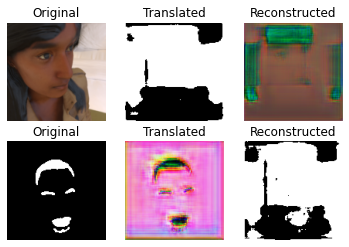

Train 6 / 10000:   2%|▏         | 1/41 [00:01<01:09,  1.74s/it]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3965 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0281 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5014 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0567 - accuracy: 0.1696
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.9527 - model_1_loss: 0.0280 - model_2_loss: 0.0569 - model_3_loss: 0.0337 - model_4_loss: 0.5390


Train 6 / 10000:   5%|▍         | 2/41 [00:02<00:54,  1.39s/it]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3606 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0273 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5015 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0521 - accuracy: 0.1901
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.5270 - model_1_loss: 0.0273 - model_2_loss: 0.0524 - model_3_loss: 0.0334 - model_4_loss: 0.3719


Train 6 / 10000:   7%|▋         | 3/41 [00:02<00:43,  1.14s/it]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3495 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0291 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.5017 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0409 - accuracy: 0.1784
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.6308 - model_1_loss: 0.0291 - model_2_loss: 0.0412 - model_3_loss: 0.0343 - model_4_loss: 0.4112


Train 6 / 10000:  10%|▉         | 4/41 [00:03<00:35,  1.03it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3510 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0279 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5024 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0387 - accuracy: 0.1946
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.5555 - model_1_loss: 0.0279 - model_2_loss: 0.0389 - model_3_loss: 0.0333 - model_4_loss: 0.4272


Train 6 / 10000:  12%|█▏        | 5/41 [00:04<00:30,  1.18it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3780 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0269 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5020 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0545 - accuracy: 0.1203
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.5943 - model_1_loss: 0.0268 - model_2_loss: 0.0547 - model_3_loss: 0.0331 - model_4_loss: 0.4612


Train 6 / 10000:  15%|█▍        | 6/41 [00:04<00:26,  1.32it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3854 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0280 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5018 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0495 - accuracy: 0.1701
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.5572 - model_1_loss: 0.0281 - model_2_loss: 0.0497 - model_3_loss: 0.0331 - model_4_loss: 0.4144


Train 6 / 10000:  17%|█▋        | 7/41 [00:05<00:23,  1.43it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3561 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0305 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.5016 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0433 - accuracy: 0.1483
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.9519 - model_1_loss: 0.0304 - model_2_loss: 0.0436 - model_3_loss: 0.0346 - model_4_loss: 0.5438


Train 6 / 10000:  20%|█▉        | 8/41 [00:05<00:21,  1.53it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3373 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0261 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.5016 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0396 - accuracy: 0.1856
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 3.4980 - model_1_loss: 0.0262 - model_2_loss: 0.0398 - model_3_loss: 0.0331 - model_4_loss: 0.3518


Train 6 / 10000:  22%|██▏       | 9/41 [00:06<00:20,  1.60it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3708 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0271 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.5014 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0419 - accuracy: 0.1786
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 3.5893 - model_1_loss: 0.0271 - model_2_loss: 0.0422 - model_3_loss: 0.0338 - model_4_loss: 0.4589


Train 6 / 10000:  24%|██▍       | 10/41 [00:06<00:18,  1.64it/s]

Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.3930 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0267 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5006 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0459 - accuracy: 0.1648
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.4560 - model_1_loss: 0.0267 - model_2_loss: 0.0462 - model_3_loss: 0.0337 - model_4_loss: 0.3810


Train 6 / 10000:  27%|██▋       | 11/41 [00:07<00:17,  1.68it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3220 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0263 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5007 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0413 - accuracy: 0.1816
Epoch 1/1
5/5 [==============================] - 0s 41ms/step - loss: 3.5322 - model_1_loss: 0.0262 - model_2_loss: 0.0416 - model_3_loss: 0.0329 - model_4_loss: 0.4017


Train 6 / 10000:  29%|██▉       | 12/41 [00:07<00:17,  1.70it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3110 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0273 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.5004 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0426 - accuracy: 0.1921
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.3897 - model_1_loss: 0.0273 - model_2_loss: 0.0429 - model_3_loss: 0.0332 - model_4_loss: 0.3777


Train 6 / 10000:  32%|███▏      | 13/41 [00:08<00:16,  1.72it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4083 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0278 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.5013 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0486 - accuracy: 0.1400
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.4973 - model_1_loss: 0.0279 - model_2_loss: 0.0489 - model_3_loss: 0.0333 - model_4_loss: 0.3933


Train 6 / 10000:  34%|███▍      | 14/41 [00:09<00:15,  1.73it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3265 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0289 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5012 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0408 - accuracy: 0.1532
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.5157 - model_1_loss: 0.0288 - model_2_loss: 0.0411 - model_3_loss: 0.0334 - model_4_loss: 0.4035


Train 6 / 10000:  37%|███▋      | 15/41 [00:09<00:14,  1.76it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3344 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0256 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 15ms/step - loss: 0.5020 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0377 - accuracy: 0.1353
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.5955 - model_1_loss: 0.0255 - model_2_loss: 0.0381 - model_3_loss: 0.0331 - model_4_loss: 0.4340


Train 6 / 10000:  39%|███▉      | 16/41 [00:10<00:14,  1.76it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3511 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0242 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5023 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0409 - accuracy: 0.1612
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.4448 - model_1_loss: 0.0241 - model_2_loss: 0.0412 - model_3_loss: 0.0329 - model_4_loss: 0.3511


Train 6 / 10000:  41%|████▏     | 17/41 [00:10<00:13,  1.77it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3270 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0254 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5022 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 15ms/step - loss: 0.0443 - accuracy: 0.1899
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.4628 - model_1_loss: 0.0254 - model_2_loss: 0.0445 - model_3_loss: 0.0329 - model_4_loss: 0.3515


Train 6 / 10000:  44%|████▍     | 18/41 [00:11<00:13,  1.75it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3291 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0259 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5002 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0433 - accuracy: 0.1377
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.5642 - model_1_loss: 0.0258 - model_2_loss: 0.0437 - model_3_loss: 0.0335 - model_4_loss: 0.4501


Train 6 / 10000:  46%|████▋     | 19/41 [00:11<00:12,  1.77it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3439 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0241 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.4997 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0430 - accuracy: 0.1365
Epoch 1/1
5/5 [==============================] - 0s 42ms/step - loss: 3.8564 - model_1_loss: 0.0240 - model_2_loss: 0.0433 - model_3_loss: 0.0328 - model_4_loss: 0.5506


Train 6 / 10000:  49%|████▉     | 20/41 [00:12<00:11,  1.76it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3735 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0229 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.5010 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0397 - accuracy: 0.1416
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.3788 - model_1_loss: 0.0229 - model_2_loss: 0.0401 - model_3_loss: 0.0327 - model_4_loss: 0.3774


Train 6 / 10000:  51%|█████     | 21/41 [00:12<00:11,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.3397 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0232 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.5007 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0477 - accuracy: 0.1334
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.5002 - model_1_loss: 0.0232 - model_2_loss: 0.0480 - model_3_loss: 0.0325 - model_4_loss: 0.4155


Train 6 / 10000:  54%|█████▎    | 22/41 [00:13<00:10,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3338 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0247 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5009 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0371 - accuracy: 0.1557
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 3.5800 - model_1_loss: 0.0246 - model_2_loss: 0.0374 - model_3_loss: 0.0336 - model_4_loss: 0.4647


Train 6 / 10000:  56%|█████▌    | 23/41 [00:14<00:10,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3221 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0216 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.5010 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0414 - accuracy: 0.1249
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.6147 - model_1_loss: 0.0216 - model_2_loss: 0.0417 - model_3_loss: 0.0333 - model_4_loss: 0.4256


Train 6 / 10000:  59%|█████▊    | 24/41 [00:14<00:09,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3233 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0221 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.5015 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0448 - accuracy: 0.1553
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.5323 - model_1_loss: 0.0221 - model_2_loss: 0.0451 - model_3_loss: 0.0330 - model_4_loss: 0.3843


Train 6 / 10000:  61%|██████    | 25/41 [00:15<00:08,  1.80it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3095 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0236 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5019 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0366 - accuracy: 0.1419
Epoch 1/1
5/5 [==============================] - 0s 37ms/step - loss: 3.4917 - model_1_loss: 0.0236 - model_2_loss: 0.0369 - model_3_loss: 0.0329 - model_4_loss: 0.4090


Train 6 / 10000:  63%|██████▎   | 26/41 [00:15<00:08,  1.81it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3583 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0231 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.5019 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0418 - accuracy: 0.1428
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.6497 - model_1_loss: 0.0230 - model_2_loss: 0.0421 - model_3_loss: 0.0338 - model_4_loss: 0.4894


Train 6 / 10000:  66%|██████▌   | 27/41 [00:16<00:07,  1.81it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3128 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0205 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.5019 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0409 - accuracy: 0.1238
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.5232 - model_1_loss: 0.0204 - model_2_loss: 0.0412 - model_3_loss: 0.0326 - model_4_loss: 0.4366


Train 6 / 10000:  68%|██████▊   | 28/41 [00:16<00:07,  1.81it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3420 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0205 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5022 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0391 - accuracy: 0.1448
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.3838 - model_1_loss: 0.0206 - model_2_loss: 0.0394 - model_3_loss: 0.0323 - model_4_loss: 0.3702


Train 6 / 10000:  71%|███████   | 29/41 [00:17<00:06,  1.80it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3193 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0236 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.5026 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0411 - accuracy: 0.1488
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.5166 - model_1_loss: 0.0237 - model_2_loss: 0.0415 - model_3_loss: 0.0333 - model_4_loss: 0.4238


Train 6 / 10000:  73%|███████▎  | 30/41 [00:17<00:06,  1.81it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3100 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0245 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5027 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0374 - accuracy: 0.1003
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.3363 - model_1_loss: 0.0245 - model_2_loss: 0.0377 - model_3_loss: 0.0341 - model_4_loss: 0.3523


Train 6 / 10000:  76%|███████▌  | 31/41 [00:18<00:05,  1.80it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3233 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0197 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5035 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0468 - accuracy: 0.1208
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.3878 - model_1_loss: 0.0197 - model_2_loss: 0.0470 - model_3_loss: 0.0332 - model_4_loss: 0.3844


Train 6 / 10000:  78%|███████▊  | 32/41 [00:19<00:04,  1.80it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3375 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0208 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.5036 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0377 - accuracy: 0.1434
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.5555 - model_1_loss: 0.0207 - model_2_loss: 0.0381 - model_3_loss: 0.0327 - model_4_loss: 0.4317


Train 6 / 10000:  80%|████████  | 33/41 [00:19<00:05,  1.54it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3478 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0206 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5037 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0424 - accuracy: 0.1254
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.8090 - model_1_loss: 0.0206 - model_2_loss: 0.0428 - model_3_loss: 0.0324 - model_4_loss: 0.4725


Train 6 / 10000:  83%|████████▎ | 34/41 [00:20<00:04,  1.59it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3087 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0208 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5042 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0403 - accuracy: 0.1339
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.3774 - model_1_loss: 0.0208 - model_2_loss: 0.0406 - model_3_loss: 0.0326 - model_4_loss: 0.3442


Train 6 / 10000:  85%|████████▌ | 35/41 [00:21<00:03,  1.65it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3715 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0218 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5031 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0401 - accuracy: 0.1164
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.3643 - model_1_loss: 0.0219 - model_2_loss: 0.0404 - model_3_loss: 0.0330 - model_4_loss: 0.3852


Train 6 / 10000:  88%|████████▊ | 36/41 [00:21<00:02,  1.70it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3130 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0202 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5031 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0420 - accuracy: 0.1153
Epoch 1/1
5/5 [==============================] - 0s 41ms/step - loss: 3.3738 - model_1_loss: 0.0203 - model_2_loss: 0.0423 - model_3_loss: 0.0325 - model_4_loss: 0.3419


Train 6 / 10000:  90%|█████████ | 37/41 [00:22<00:02,  1.72it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3176 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0211 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.5041 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0344 - accuracy: 0.1362
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.5096 - model_1_loss: 0.0211 - model_2_loss: 0.0347 - model_3_loss: 0.0327 - model_4_loss: 0.4104


Train 6 / 10000:  93%|█████████▎| 38/41 [00:22<00:01,  1.74it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3053 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0203 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5043 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0442 - accuracy: 0.1348
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.7068 - model_1_loss: 0.0203 - model_2_loss: 0.0444 - model_3_loss: 0.0326 - model_4_loss: 0.4156


Train 6 / 10000:  95%|█████████▌| 39/41 [00:23<00:01,  1.76it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3854 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0200 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5040 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0410 - accuracy: 0.1271
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.3835 - model_1_loss: 0.0201 - model_2_loss: 0.0413 - model_3_loss: 0.0346 - model_4_loss: 0.3545


Train 6 / 10000:  98%|█████████▊| 40/41 [00:23<00:00,  1.77it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3559 - accuracy: 7.9346e-04
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0188 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5033 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0408 - accuracy: 0.1123
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 3.4728 - model_1_loss: 0.0189 - model_2_loss: 0.0411 - model_3_loss: 0.0328 - model_4_loss: 0.3335


Train 7 / 10000:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3007 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0196 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5042 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0359 - accuracy: 0.1365
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.4738 - model_1_loss: 0.0197 - model_2_loss: 0.0361 - model_3_loss: 0.0345 - model_4_loss: 0.3731


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


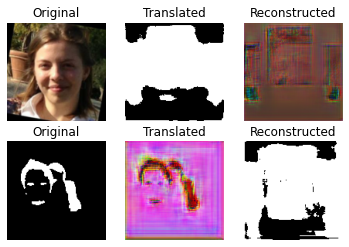

Train 7 / 10000:   2%|▏         | 1/41 [00:02<01:22,  2.07s/it]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3097 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0193 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5034 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0370 - accuracy: 0.1506
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.6503 - model_1_loss: 0.0193 - model_2_loss: 0.0373 - model_3_loss: 0.0331 - model_4_loss: 0.4686


Train 7 / 10000:   5%|▍         | 2/41 [00:02<01:03,  1.62s/it]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3189 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0190 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.5025 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0358 - accuracy: 0.1372
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.3958 - model_1_loss: 0.0189 - model_2_loss: 0.0361 - model_3_loss: 0.0337 - model_4_loss: 0.3886


Train 7 / 10000:   7%|▋         | 3/41 [00:03<00:49,  1.30s/it]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3195 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0176 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5018 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0409 - accuracy: 0.1118
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.3525 - model_1_loss: 0.0175 - model_2_loss: 0.0412 - model_3_loss: 0.0325 - model_4_loss: 0.3875


Train 7 / 10000:  10%|▉         | 4/41 [00:03<00:40,  1.08s/it]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3487 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0186 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.5020 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0462 - accuracy: 0.0849
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.4646 - model_1_loss: 0.0186 - model_2_loss: 0.0465 - model_3_loss: 0.0323 - model_4_loss: 0.4396


Train 7 / 10000:  12%|█▏        | 5/41 [00:04<00:33,  1.08it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2953 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0185 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5034 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0398 - accuracy: 0.1153
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 3.4988 - model_1_loss: 0.0185 - model_2_loss: 0.0401 - model_3_loss: 0.0324 - model_4_loss: 0.4032


Train 7 / 10000:  15%|█▍        | 6/41 [00:04<00:28,  1.23it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3606 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0181 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5054 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0384 - accuracy: 0.0849
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.7170 - model_1_loss: 0.0180 - model_2_loss: 0.0388 - model_3_loss: 0.0323 - model_4_loss: 0.5277


Train 7 / 10000:  17%|█▋        | 7/41 [00:05<00:24,  1.36it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3341 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0182 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.5066 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0435 - accuracy: 0.1068
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.6450 - model_1_loss: 0.0182 - model_2_loss: 0.0438 - model_3_loss: 0.0323 - model_4_loss: 0.4813


Train 7 / 10000:  20%|█▉        | 8/41 [00:05<00:22,  1.46it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3041 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0185 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5073 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0386 - accuracy: 0.1194
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.5451 - model_1_loss: 0.0185 - model_2_loss: 0.0389 - model_3_loss: 0.0324 - model_4_loss: 0.4475


Train 7 / 10000:  22%|██▏       | 9/41 [00:06<00:20,  1.54it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3316 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0185 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.5074 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0351 - accuracy: 0.1311
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.3529 - model_1_loss: 0.0185 - model_2_loss: 0.0354 - model_3_loss: 0.0330 - model_4_loss: 0.3830


Train 7 / 10000:  24%|██▍       | 10/41 [00:07<00:19,  1.60it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3263 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0166 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.5068 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0362 - accuracy: 0.1193
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.3500 - model_1_loss: 0.0167 - model_2_loss: 0.0366 - model_3_loss: 0.0330 - model_4_loss: 0.3418


Train 7 / 10000:  27%|██▋       | 11/41 [00:07<00:18,  1.66it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3116 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0202 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 15ms/step - loss: 0.5069 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0424 - accuracy: 0.0896
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.5731 - model_1_loss: 0.0201 - model_2_loss: 0.0428 - model_3_loss: 0.0325 - model_4_loss: 0.3952


Train 7 / 10000:  29%|██▉       | 12/41 [00:08<00:17,  1.67it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3119 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0174 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.5081 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0362 - accuracy: 0.1273
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.3587 - model_1_loss: 0.0174 - model_2_loss: 0.0365 - model_3_loss: 0.0327 - model_4_loss: 0.4013


Train 7 / 10000:  32%|███▏      | 13/41 [00:08<00:16,  1.70it/s]

Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.3550 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0157 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.5076 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0394 - accuracy: 0.1166
Epoch 1/1
5/5 [==============================] - 0s 42ms/step - loss: 3.2896 - model_1_loss: 0.0157 - model_2_loss: 0.0398 - model_3_loss: 0.0321 - model_4_loss: 0.3490


Train 7 / 10000:  34%|███▍      | 14/41 [00:09<00:15,  1.71it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3449 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0171 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5075 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0363 - accuracy: 0.1392
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.5271 - model_1_loss: 0.0171 - model_2_loss: 0.0367 - model_3_loss: 0.0328 - model_4_loss: 0.4733


Train 7 / 10000:  37%|███▋      | 15/41 [00:09<00:14,  1.74it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3476 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0164 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5075 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 14ms/step - loss: 0.0375 - accuracy: 0.1400
Epoch 1/1
5/5 [==============================] - 0s 42ms/step - loss: 3.4530 - model_1_loss: 0.0164 - model_2_loss: 0.0379 - model_3_loss: 0.0322 - model_4_loss: 0.4047


Train 7 / 10000:  39%|███▉      | 16/41 [00:10<00:14,  1.74it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3288 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0167 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5078 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0373 - accuracy: 0.1380
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.4174 - model_1_loss: 0.0168 - model_2_loss: 0.0377 - model_3_loss: 0.0323 - model_4_loss: 0.3679


Train 7 / 10000:  41%|████▏     | 17/41 [00:11<00:13,  1.76it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3892 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0187 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.5082 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0385 - accuracy: 0.1366
Epoch 1/1
5/5 [==============================] - 0s 37ms/step - loss: 3.3530 - model_1_loss: 0.0188 - model_2_loss: 0.0388 - model_3_loss: 0.0327 - model_4_loss: 0.3957


Train 7 / 10000:  44%|████▍     | 18/41 [00:11<00:12,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.2750 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0159 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5088 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0343 - accuracy: 0.1141
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.4087 - model_1_loss: 0.0159 - model_2_loss: 0.0346 - model_3_loss: 0.0324 - model_4_loss: 0.3721


Train 7 / 10000:  46%|████▋     | 19/41 [00:12<00:12,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.3124 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0164 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5090 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0367 - accuracy: 0.1225
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.6896 - model_1_loss: 0.0164 - model_2_loss: 0.0370 - model_3_loss: 0.0328 - model_4_loss: 0.4895


Train 7 / 10000:  49%|████▉     | 20/41 [00:12<00:11,  1.78it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4418 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0161 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.5077 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0379 - accuracy: 0.0909
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.6041 - model_1_loss: 0.0162 - model_2_loss: 0.0383 - model_3_loss: 0.0325 - model_4_loss: 0.5388


Train 7 / 10000:  51%|█████     | 21/41 [00:13<00:11,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3410 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0184 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.5078 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0396 - accuracy: 0.1110
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 3.4235 - model_1_loss: 0.0183 - model_2_loss: 0.0400 - model_3_loss: 0.0328 - model_4_loss: 0.4204


Train 7 / 10000:  54%|█████▎    | 22/41 [00:13<00:10,  1.80it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.4259 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0171 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.5087 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.0373 - accuracy: 0.1933
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.3999 - model_1_loss: 0.0173 - model_2_loss: 0.0375 - model_3_loss: 0.0327 - model_4_loss: 0.3490


Train 7 / 10000:  56%|█████▌    | 23/41 [00:14<00:09,  1.80it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2976 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0211 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5068 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0311 - accuracy: 0.0676
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.5189 - model_1_loss: 0.0211 - model_2_loss: 0.0315 - model_3_loss: 0.0361 - model_4_loss: 0.4108


Train 7 / 10000:  59%|█████▊    | 24/41 [00:14<00:09,  1.79it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2829 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0129 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.5066 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0357 - accuracy: 0.2320
Epoch 1/1
5/5 [==============================] - 0s 42ms/step - loss: 3.6053 - model_1_loss: 0.0125 - model_2_loss: 0.0360 - model_3_loss: 0.0364 - model_4_loss: 0.4701


Train 7 / 10000:  61%|██████    | 25/41 [00:15<00:08,  1.80it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3688 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.0126 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.5064 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0436 - accuracy: 0.1042
Epoch 1/1
5/5 [==============================] - 0s 38ms/step - loss: 3.4463 - model_1_loss: 0.0127 - model_2_loss: 0.0439 - model_3_loss: 0.0354 - model_4_loss: 0.3752


Train 7 / 10000:  63%|██████▎   | 26/41 [00:16<00:08,  1.81it/s]

Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.3365 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0135 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.5079 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0364 - accuracy: 0.1049
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.2995 - model_1_loss: 0.0135 - model_2_loss: 0.0368 - model_3_loss: 0.0335 - model_4_loss: 0.3737


Train 7 / 10000:  66%|██████▌   | 27/41 [00:16<00:07,  1.80it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.2653 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0160 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.5077 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0330 - accuracy: 0.1093
Epoch 1/1
5/5 [==============================] - 0s 40ms/step - loss: 3.3719 - model_1_loss: 0.0160 - model_2_loss: 0.0334 - model_3_loss: 0.0330 - model_4_loss: 0.3555


Train 7 / 10000:  68%|██████▊   | 28/41 [00:17<00:07,  1.80it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3229 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0183 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 13ms/step - loss: 0.5082 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0408 - accuracy: 0.0912
Epoch 1/1
5/5 [==============================] - 0s 39ms/step - loss: 3.4283 - model_1_loss: 0.0183 - model_2_loss: 0.0412 - model_3_loss: 0.0332 - model_4_loss: 0.3976


Train 7 / 10000:  71%|███████   | 29/41 [00:17<00:06,  1.80it/s]

Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.3017 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0167 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 11ms/step - loss: 0.5098 - accuracy: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 0s 12ms/step - loss: 0.0357 - accuracy: 0.1073
Epoch 1/1


In [ ]:
gan = SegGAN()
gan.train(epochs=10000, batch_size=5, sample_interval=100, verbose=True)

In [ ]:
imgs = gan.sample_images(1, 1)

In [ ]:
imgs = gan.data_loader.load_data(domain="S", batch_size=1, is_testing=True)

In [ ]:
imgs[0].max()